In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request, urllib.parse, urllib.error
from bs4 import BeautifulSoup
import requests
import re
import json
from datetime import datetime
from bidi.algorithm import get_display
import arabic_reshaper
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import category_encoders as ce
from sklearn.decomposition import PCA
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_moons
import umap
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
import requests
import pandas as pd

url = 'https://data.gov.il/api/3/action/datastore_search?resource_id=851ecab1-0622-4dbe-a6c7-f950cf82abf9&limit=30000'
response = requests.get(url)

if response.status_code == 200:
    json_data = response.json()
    records = json_data['result']['records']
    df = pd.DataFrame(records)
    df.head()
else:
    print(f"Failed to fetch data, status code: {response.status_code}")


In [3]:
df = df.copy()
df.head()

,_id,mispar_rechev,tozeret_cd,tozeret_nm,degem_cd,degem_nm,sug_rechev_cd,sug_rechev_nm,moed_aliya_lakvish,bitul_dt,...,ramat_eivzur_betihuty,kvutzat_zihum,shnat_yitzur,baalut,tzeva_rechev,zmig_kidmi,zmig_ahori,sug_delek_nm,horaat_rishum,kinuy_mishari
0,1,7878876,724,פולקסווגן גרמנ,0365,7EMH49,341,מרכב אחוד,2012,2019-06-02,...,0,15,2012,פרטי,שחור פנינה,255/45 R18,255/45 R18,דיזל,120191,T5
1,2,8659075,776,פורד תורכיה,0005,PT2,341,מרכב אחוד,2012,2019-05-07,...,0,15,2012,פרטי,שנהב לבן,195/65R15,195/65R15,דיזל,121663,TOURNEO CONNECT
2,3,4647513,177,פיאט תורכיה,0020,263WXC1A,341,מרכב אחוד,2012,2019-02-19,...,0,15,2012,פרטי,שנהב לבן,195/65R15,195/65R15,דיזל,0,DOBLO1.3
3,4,8663163,885,קיה קוריאה,0029,JC5248,341,מרכב אחוד,,2019-12-02,...,0,0,2008,פרטי,שנהב לבן,245/70R16,245/70R16,דיזל,0,SORENTO
4,5,5286460,885,קיה קוריאה,0019,MB7543,341,מרכב אחוד,,2020-03-03,...,0,0,2007,פרטי,כסף מטלי,225/70R16,225/70R16,דיזל,0,CARNIVAL


In [4]:
df.shape

(30000, 26)

In [5]:
df.columns

Index(['_id', 'mispar_rechev', 'tozeret_cd', 'tozeret_nm', 'degem_cd',
       'degem_nm', 'sug_rechev_cd', 'sug_rechev_nm', 'moed_aliya_lakvish',
       'bitul_dt', 'misgeret', 'tozar_manoa', 'degem_manoa', 'mispar_manoa',
       'mishkal_kolel', 'ramat_gimur', 'ramat_eivzur_betihuty',
       'kvutzat_zihum', 'shnat_yitzur', 'baalut', 'tzeva_rechev', 'zmig_kidmi',
       'zmig_ahori', 'sug_delek_nm', 'horaat_rishum', 'kinuy_mishari'],
      dtype='object')

In [6]:
df.dtypes

_id                       int64
mispar_rechev             int64
tozeret_cd                int64
tozeret_nm               object
degem_cd                 object
degem_nm                 object
sug_rechev_cd             int64
sug_rechev_nm            object
moed_aliya_lakvish       object
bitul_dt                 object
misgeret                 object
tozar_manoa              object
degem_manoa              object
mispar_manoa             object
mishkal_kolel             int64
ramat_gimur              object
ramat_eivzur_betihuty     int64
kvutzat_zihum             int64
shnat_yitzur              int64
baalut                   object
tzeva_rechev             object
zmig_kidmi               object
zmig_ahori               object
sug_delek_nm             object
horaat_rishum             int64
kinuy_mishari            object
dtype: object

In [7]:
df.replace({'': np.nan, ' ': np.nan}, inplace=True)

# **Data Preprocessing**
<ul>
<li>missing values.</li>
<li>Scaling.</li>
<li>Converting categorical variables to numerical.</li>
</ul>

In [8]:
df.isnull().sum().sort_values()

_id                          0
ramat_eivzur_betihuty        0
baalut                       0
mishkal_kolel                0
tzeva_rechev                 0
horaat_rishum                0
misgeret                     0
kvutzat_zihum                0
bitul_dt                     0
sug_rechev_nm                0
sug_rechev_cd                0
degem_nm                     0
sug_delek_nm                 0
tozeret_nm                   0
tozeret_cd                   0
mispar_rechev                0
shnat_yitzur                 0
zmig_kidmi                  58
tozar_manoa                188
degem_manoa                189
mispar_manoa               235
zmig_ahori                2545
degem_cd                  3340
kinuy_mishari             3499
ramat_gimur               4176
moed_aliya_lakvish       13906
dtype: int64

##### Before handling the columns, we will check if there are rows that have a lot of missing information and we will consider the possibility of removing them

In [9]:
def count_rows_with_empty_values(df, threshold):
    num_empty_values = df.isnull().sum(axis=1)
    rows_with_empty_values = (num_empty_values > threshold).sum()
    return rows_with_empty_values

In [10]:
rows_with_empty = count_rows_with_empty_values(df, threshold=3)
print(f"Number of rows with more than 3 empty values: {rows_with_empty}")

Number of rows with more than 3 empty values: 1598


##### There are relatively few rows with a lot of empty values, so to decide whether to remove these rows we first chose to deal with the problematic columns that have a lot of empty values and then we will check again

### columns summary:

1. `mispar_rechev`: Numeric column representing the vehicle's number.
2. `tozeret_cd`: Numeric column representing a code associated with the vehicle's manufacturer.
3. `tozeret_nm`: Text column representing the name of the vehicle's manufacturer.
4. `degem_cd`: Text column representing a code associated with the vehicle's model.
5. `degem_nm`: Text column representing the name of the vehicle's model.
6. `sug_rechev_cd`: Numeric column representing a code associated with the vehicle's type.
7. `sug_rechev_nm`: Text column representing the name of the vehicle's type.
8. `moed_aliya_lakvish`: Text column representing the date of vehicle's import.
9. `bitul_dt`: Text column representing the date of vehicle's cancellation.
10. `misgeret`: Text column representing the vehicle's classification.
11. `tozar_manoa`: Text column representing the manufacturer's code.
12. `degem_manoa`: Text column representing the model's code.
13. `mispar_manoa`: Text column representing the vehicle's number within a model.
14. `mishkal_kolel`: Numeric column representing the vehicle's weight.
15. `ramat_gimur`: Text column representing the vehicle's assembly status.
16. `ramat_eivzur_betihuty`: Numeric column representing the vehicle's insured value.
17. `kvutzat_zihum`: Numeric column representing the assembly group.
18. `shnat_yitzur`: Numeric column representing the production year.
19. `baalut`: Text column representing the vehicle's condition.
20. `tzeva_rechev`: Text column representing the vehicle's color.
21. `zmig_kidmi`: Text column representing the internal fuel system.
22. `zmig_ahori`: Text column representing the external fuel system.
23. `sug_delek_nm`: Text column representing the name of the fuel type.
24. `horaat_rishum`: Numeric column representing the registration status.
25. `kinuy_mishari`: Text column representing the vehicle's registration mark.

In [11]:
df['mispar_manoa'].nunique()

29706

In [12]:
df['misgeret'].nunique()

29999

#### After preliminary research, we discovered that the columns 'misgeret', '_id', 'mispar_rechev' and 'mispar_manoa' contain single-valued values without meaning. Therefore we have no way to use them during the process.

In [13]:
df.drop(['_id','mispar_rechev','mispar_manoa','misgeret'], axis=1, inplace=True)

## **missing values**

##### We will build a function that checks for compatibility between 2 single-valued columns each time to check if there is redundant data

In [14]:
def columns_correlation_numeric(df,column1,column2):
    df[column2] = pd.to_numeric(df[column2], errors='coerce')
    df[column1] = pd.to_numeric(df[column1], errors='coerce')
    filtered_df1= df.dropna(subset=[column1,column2])
    matching_rows = filtered_df1[filtered_df1[column1] == filtered_df1[column2]]
    percentage_matching = (len(matching_rows) / len(filtered_df1)) * 100
    print(f"Percentage of rows where {column1} matches {column2}: {percentage_matching:.2f}%")

In [15]:
def columns_correlation_str(df, column1, column2, threshold):
    # Create an empty dictionary to store values from column2 for each unique value in column1
    filtered_df1= df.dropna(subset=[column1,column2])
    column1_to_column2_values = {}
    column2_to_column1_values = {}
    
    # Populate the dictionaries
    for value in filtered_df1[column1].unique():
        column1_to_column2_values[value] = filtered_df1.loc[filtered_df1[column1] == value, column2].unique().tolist()
    for value in filtered_df1[column2].unique():
        column2_to_column1_values[value] = filtered_df1.loc[filtered_df1[column2] == value, column1].unique().tolist()
    
    # Calculate the percentage of keys with list length equal to 1 for each alternative
    single_value_percentage_1 = sum(1 for values in column1_to_column2_values.values() if len(values) == 1) / len(column1_to_column2_values) * 100
    single_value_percentage_2 = sum(1 for values in column2_to_column1_values.values() if len(values) == 1) / len(column2_to_column1_values) * 100
    
    # Check if any of the percentages exceed the threshold
    if single_value_percentage_1 > threshold and single_value_percentage_2 > threshold:
        print(f"Percentage of keys from column 1 with list length equal to 1: {single_value_percentage_1:.2f}%")
        print(f"Percentage of keys from column 2 with list length equal to 1: {single_value_percentage_2:.2f}%")
    elif single_value_percentage_1 > threshold:
        print(f"Column '{column2}' does not meet the condition with a percentage of {single_value_percentage_2:.2f}%, while column '{column1}' meets the condition with a percentage of {single_value_percentage_1:.2f}%.")
    elif single_value_percentage_2 > threshold:
        print(f"Column '{column1}' does not meet the condition with a percentage of {single_value_percentage_1:.2f}%, while column '{column2}' meets the condition with a percentage of {single_value_percentage_2:.2f}%.")
    else:
        print(f"Neither alternative has a percentage greater than the threshold value of {threshold}.Column '{column1}'-{single_value_percentage_1:.2f}% and Column '{column2}'-{single_value_percentage_2:.2f}%")


#### <blockquote> moed_aliya_lakvish and shnat_yitzur</blockquote>

In [16]:
df['moed_aliya_lakvish'].unique()

array(['2012', nan, '2008', '2010', '2009', '2011', '2014', '2013',
       '2015', '2016', '2017', '2023', '2018', '2019', '2021', '2020',
       '2022', '2007', '1996', '2003', '2024', '2002', '2004', '2005',
       '2006', '1960'], dtype=object)

In [17]:
df['moed_aliya_lakvish'].isnull().sum()

13906

##### We check a match between 2 columns moed_aliya_lakvish and shnat_yitzur

In [18]:
columns_correlation_numeric(df, 'shnat_yitzur', 'moed_aliya_lakvish')

Percentage of rows where shnat_yitzur matches moed_aliya_lakvish: 100.00%


In [19]:
df.rename(columns={'shnat_yitzur': 'shnat_yitzur_and_aliya_lakvish'}, inplace=True)

In [20]:
df.drop('moed_aliya_lakvish', axis=1, inplace=True)

In [21]:
df.columns

Index(['tozeret_cd', 'tozeret_nm', 'degem_cd', 'degem_nm', 'sug_rechev_cd',
       'sug_rechev_nm', 'bitul_dt', 'tozar_manoa', 'degem_manoa',
       'mishkal_kolel', 'ramat_gimur', 'ramat_eivzur_betihuty',
       'kvutzat_zihum', 'shnat_yitzur_and_aliya_lakvish', 'baalut',
       'tzeva_rechev', 'zmig_kidmi', 'zmig_ahori', 'sug_delek_nm',
       'horaat_rishum', 'kinuy_mishari'],
      dtype='object')

##### After we are done with the columns that contained the most missing values, we will check again the data density in the rows

In [22]:
rows_with_empty = count_rows_with_empty_values(df, threshold=3)
print(f"Number of rows with more than 3 empty values: {rows_with_empty}")

Number of rows with more than 3 empty values: 668


In [23]:
rows_with_empty = count_rows_with_empty_values(df, threshold=4)
print(f"Number of rows with more than 4 empty values: {rows_with_empty}")

Number of rows with more than 4 empty values: 189


In [24]:
df = df.dropna(thresh=20)

In [25]:
df.shape

(26388, 21)

In [26]:
def remove_empty_values(df, columns):
    for col in columns:
        empty_values_count = df[col].isnull().sum()
        if 0 < empty_values_count < 1000:
            df = df.dropna(subset=[col])
            print(f"Removed {empty_values_count} rows with empty values from column '{col}'")
        elif empty_values_count >= 1000:
            print(f"More than 1000 empty values in column '{col}'")
    return df

In [27]:
df = remove_empty_values(df,df.columns.tolist())

Removed 564 rows with empty values from column 'ramat_gimur'
Removed 21 rows with empty values from column 'zmig_kidmi'
More than 1000 empty values in column 'zmig_ahori'


#### <blockquote> bitul_dt </blockquote>

In [28]:
df['bitul_dt'].unique()

array(['2019-06-02', '2019-05-07', '2019-02-19', ..., '2020-10-14',
       '2021-01-01', '2021-02-21'], dtype=object)

##### We will only save the month and year values, the day from the date is not currently relevant

In [29]:
df['bitul_dt'] = pd.to_datetime(df['bitul_dt'])
df['bitul_dt'] = df['bitul_dt'].dt.to_period('M')

In [30]:
df['bitul_year'] = df['bitul_dt'].dt.year
df['bitul_month'] = df['bitul_dt'].dt.month
df.drop('bitul_dt', axis=1, inplace=True)

#### <blockquote> zmig_ahori </blockquote>

In [31]:
df['zmig_ahori'].isnull().sum()

1795

In [32]:
df['zmig_ahori'].nunique()

741

##### We can see that the absolute majority of the vehicles are found with the same type of tires on the back and front, therefore we will fill in empty values in this column according to the values in the column of the front tire.
##### We will leave the rows where the values are different between the tires to investigate this type of data later and examine whether their recall is affected by the difference (in all the times we ran, about 10% of the data came out)

In [33]:
columns_correlation_str(df, 'zmig_ahori', 'zmig_kidmi',90)

Column 'zmig_kidmi' does not meet the condition with a percentage of 89.08%, while column 'zmig_ahori' meets the condition with a percentage of 95.14%.


In [34]:
df['zmig_ahori'].fillna(df['zmig_kidmi'], inplace=True)

#### <blockquote> degem_cd </blockquote>

##### We know that the degem_cd column shows for each value (the values are meaningless and single-valued) a fixed result in the degem_nm column.
##### For this reason we chose to remove the degem_cd column because the information we need is in the degem_nm column.
##### degem_cd: Text column representing a code associated with the vehicle's model.
##### degem_nm: Text column representing the name of the vehicle's model.

In [35]:
df.drop('degem_cd', axis=1, inplace=True)

#### <blockquote> kinuy_mishari </blockquote>

In [36]:
df['kinuy_mishari'].isnull().sum()

0

In [37]:
df_filtered = df.dropna(subset=['kinuy_mishari'])
most_frequent_kinuy = df_filtered.groupby('tozeret_nm')['kinuy_mishari'].agg(lambda x: x.mode().iloc[0])
kinuy_mapping = most_frequent_kinuy.to_dict()
df['kinuy_mishari'] = df.apply(lambda row: kinuy_mapping.get(row['tozeret_nm'], row['kinuy_mishari']), axis=1)

In [38]:
df['kinuy_mishari'].isnull().sum()

0

In [39]:
df = df.dropna(subset='kinuy_mishari')
df['kinuy_mishari'].isnull().sum()

0

#### <blockquote> ramat_gimur </blockquote>

In [40]:
df['ramat_gimur'].isnull().sum()

0

In [41]:
df['ramat_gimur'].nunique()

853

In [42]:
def mode_or_none(x):
    modes = x.mode()
    return modes[0] if not modes.empty else None if len(modes) == 0 else modes

most_frequent_per_group = df.groupby(['shnat_yitzur_and_aliya_lakvish', 'tozeret_nm', 'kinuy_mishari'])[['ramat_gimur']].agg(mode_or_none)
most_frequent_per_group.dropna(subset=['ramat_gimur'], inplace=True)

for index, value in most_frequent_per_group.iterrows():
     condition = (df['shnat_yitzur_and_aliya_lakvish'] == index[0]) & (df['tozeret_nm'] == index[1]) & (df['kinuy_mishari'] == index[2]) & ((df['ramat_gimur'].isnull()) | (df['ramat_gimur'] == ''))
     df.loc[condition, 'ramat_gimur'] = value['ramat_gimur'][0]

In [43]:
df['ramat_gimur'].isnull().sum()

0

In [44]:
df = df.dropna(subset='ramat_gimur')

In [45]:
df.isnull().sum().sort_values()

tozeret_cd                        0
kinuy_mishari                     0
horaat_rishum                     0
sug_delek_nm                      0
zmig_ahori                        0
zmig_kidmi                        0
tzeva_rechev                      0
baalut                            0
shnat_yitzur_and_aliya_lakvish    0
bitul_year                        0
kvutzat_zihum                     0
ramat_gimur                       0
mishkal_kolel                     0
degem_manoa                       0
tozar_manoa                       0
sug_rechev_nm                     0
sug_rechev_cd                     0
degem_nm                          0
tozeret_nm                        0
ramat_eivzur_betihuty             0
bitul_month                       0
dtype: int64

#### <blockquote> tozeret_cd & tozeret_nm </blockquote>

In [46]:
columns_correlation_str(df, 'tozeret_cd', 'tozeret_nm',90)

Percentage of keys from column 1 with list length equal to 1: 100.00%
Percentage of keys from column 2 with list length equal to 1: 100.00%


In [47]:
df.drop('tozeret_cd', axis=1, inplace=True)

#### <blockquote> sug_rechev_nm & sug_rechev_cd </blockquote>

In [48]:
columns_correlation_str(df,'sug_rechev_nm','sug_rechev_cd',90)

Percentage of keys from column 1 with list length equal to 1: 95.00%
Percentage of keys from column 2 with list length equal to 1: 100.00%


In [49]:
df.drop('sug_rechev_cd', axis=1, inplace=True)

In [50]:
replacements = {'פרטי': 'private','חברה': 'company','ליסינג': 'leasing','השכרה': 'rent'}
df['baalut'] = df['baalut'].replace(replacements)
replacements = {'בנזין': 'Gasolin','גפ"מ': 'LPG','דיזל': 'diesel','חשמל': 'elc','חשמל/בנזין': 'electricity/gasoline','חשמל/דיזל': 'electricity/diesel'}
df['sug_delek_nm'] = df['sug_delek_nm'].replace(replacements)

In [51]:
df.columns

Index(['tozeret_nm', 'degem_nm', 'sug_rechev_nm', 'tozar_manoa', 'degem_manoa',
       'mishkal_kolel', 'ramat_gimur', 'ramat_eivzur_betihuty',
       'kvutzat_zihum', 'shnat_yitzur_and_aliya_lakvish', 'baalut',
       'tzeva_rechev', 'zmig_kidmi', 'zmig_ahori', 'sug_delek_nm',
       'horaat_rishum', 'kinuy_mishari', 'bitul_year', 'bitul_month'],
      dtype='object')

In [52]:
df.shape

(25803, 19)

# --------------------------------------------------------------------------

## **Scaling**

#### <blockquote> mishkal_kolel </blockquote>

In [53]:
df[['mishkal_kolel']].describe()

,mishkal_kolel
count,25803.000000
mean,1353.998760
std,806.603265
min,0.000000
25%,1276.000000
50%,1620.000000
75%,1844.000000
max,3500.000000


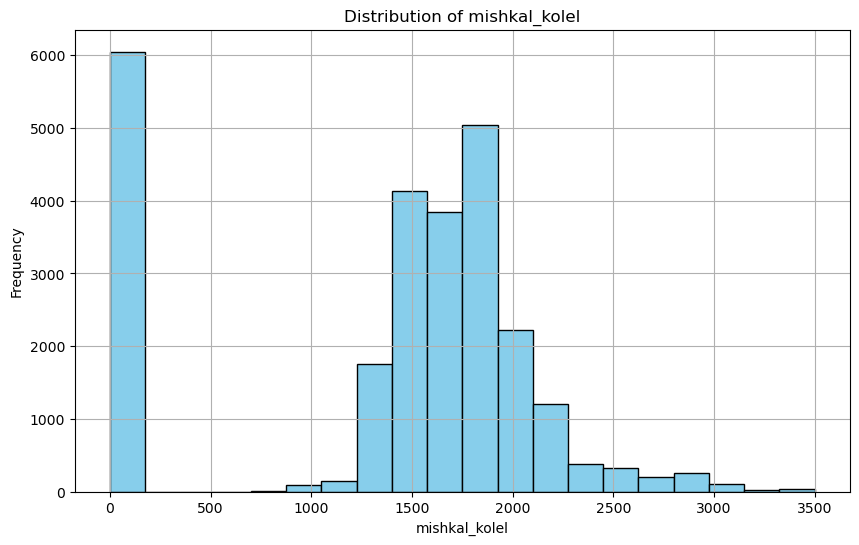

In [54]:
plt.figure(figsize=(10, 6))
plt.hist(df['mishkal_kolel'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of mishkal_kolel')
plt.xlabel('mishkal_kolel')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

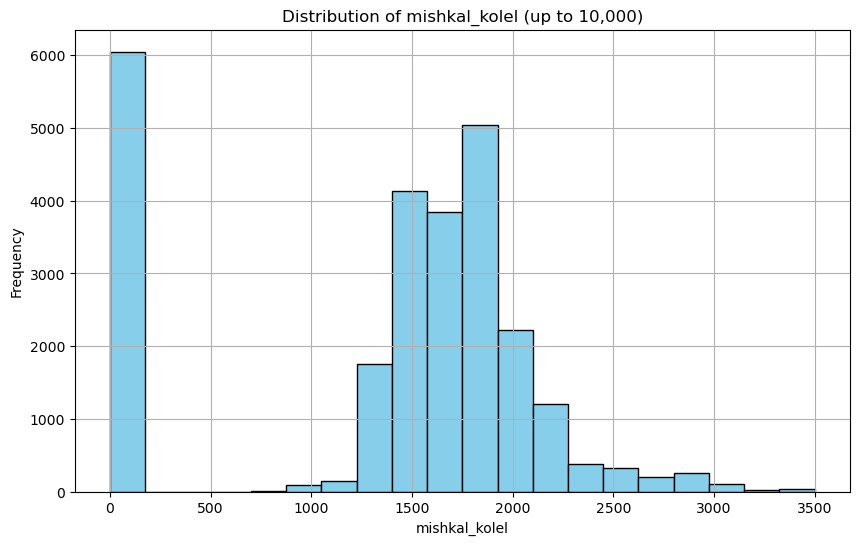

In [55]:
df_0_10000 = df[df['mishkal_kolel'] <= 10000]
plt.figure(figsize=(10, 6))
plt.hist(df_0_10000['mishkal_kolel'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of mishkal_kolel (up to 10,000)')
plt.xlabel('mishkal_kolel')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

##### Note - the average weight of a private car is about 1500 kilograms.

In [56]:
mishkal_1000 = df[df['mishkal_kolel'] < 1000]
len(mishkal_1000)/len(df)

0.2368716815874123

In [57]:
mishkal_2000 = df[(2000 > df['mishkal_kolel']) & (df['mishkal_kolel'] >= 1000)]
len(mishkal_2000)/len(df)

0.6325233499980623

In [58]:
mishkal_3000 = df[(3000 > df['mishkal_kolel']) & (df['mishkal_kolel'] >= 2000)]
len(mishkal_3000)/len(df)

0.12444289423710421

In [59]:
mishkal_top = df[df['mishkal_kolel'] >= 3000]
len(mishkal_top)/len(df)

0.0061620741774212305

##### we know that the weight of an average car is 1500 kilograms, so we will check if there is a logical explanation for the rows below 1000 kilograms

In [60]:
mishkal_1000.tail()

,tozeret_nm,degem_nm,sug_rechev_nm,tozar_manoa,degem_manoa,mishkal_kolel,ramat_gimur,ramat_eivzur_betihuty,kvutzat_zihum,shnat_yitzur_and_aliya_lakvish,baalut,tzeva_rechev,zmig_kidmi,zmig_ahori,sug_delek_nm,horaat_rishum,kinuy_mishari,bitul_year,bitul_month
29961,הונדה-יפן,ES סיוויק ES5671P,פרטי נוסעים,הונדה יפן,D16V1,0,ES,0,0,2002,private,זהב,185/70/R14,185/70/R14,Gasolin,0,ACCORD,2024,1
29962,טויוטה יפן,ZZE112L - AEPNKW,פרטי נוסעים,טויוטה יפן,3ZZ,0,GLI,0,0,2001,private,כסף,185\65 R14,185\65 R14,Gasolin,0,COROLLA,2024,1
29963,פורד ספרד,DFW,פרטי נוסעים,ספרד פורד,FYD,0,LX,0,0,2004,private,כסף,185/65R14,185/65R14,Gasolin,0,FOCUS,2022,12
29964,מזדה יפן,GG12F,פרטי נוסעים,יפן מאזדה,LF,0,EXECUTIVE,0,0,2004,private,כסף,205/55/16,205/55/16,Gasolin,0,MAZDA 3,2022,3
29965,סובארו יפן,BL5ALHL,פרטי נוסעים,פוג'י,EJ 20,0,20 I,0,0,2004,private,שנהב לבן,205/55R/16,205/55R/16,Gasolin,0,IMPREZA,2021,1


In [61]:
mishkal_1000['sug_rechev_nm'].unique()

array(['פרטי נוסעים', 'מונית', 'פרטי נוסעים 5 דלתות', 'פרטי נוסעים פתוח',
       'פרטי נוסעים 3 דלתות'], dtype=object)

In [62]:
def fill_missing_mishkal_kolel(df, values):
    for value in values:
        med_mishkal = df.loc[(df['sug_rechev_nm'] == value) & (df['mishkal_kolel'] != 0), 'mishkal_kolel'].median()
        if med_mishkal > 0:
            df.loc[(df['sug_rechev_nm'] == value) & (df['mishkal_kolel'] == 0), 'mishkal_kolel'] = med_mishkal
            print(f"Filled missing mishkal_kolel values with the median {med_mishkal:.2f} for rows where sug_rechev_nm is '{value}'.")
    x = df[df['mishkal_kolel'] == 0].index
    df = df.drop(x)
    print(x.shape)
    return df

In [63]:
fill_missing_mishkal_kolel(df,list(mishkal_1000['sug_rechev_nm'].unique()))
x=df[df['mishkal_kolel'] == 0].index
df=df.drop(x)

Filled missing mishkal_kolel values with the median 1760.00 for rows where sug_rechev_nm is 'פרטי נוסעים'.
Filled missing mishkal_kolel values with the median 1955.00 for rows where sug_rechev_nm is 'מונית'.
Filled missing mishkal_kolel values with the median 1560.00 for rows where sug_rechev_nm is 'פרטי נוסעים 5 דלתות'.
Filled missing mishkal_kolel values with the median 1355.00 for rows where sug_rechev_nm is 'פרטי נוסעים פתוח'.
Filled missing mishkal_kolel values with the median 1553.00 for rows where sug_rechev_nm is 'פרטי נוסעים 3 דלתות'.
(0,)


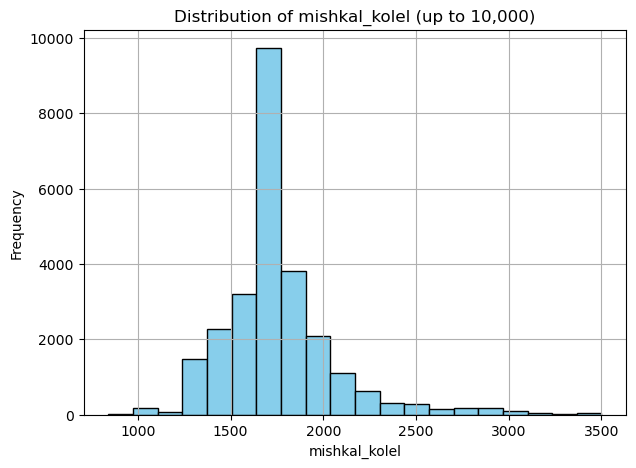

In [64]:
df_0_10000 = df[df['mishkal_kolel'] <= 10000]
plt.figure(figsize=(7, 5))
plt.hist(df_0_10000['mishkal_kolel'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of mishkal_kolel (up to 10,000)')
plt.xlabel('mishkal_kolel')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [65]:
counts_df = pd.DataFrame(columns=['Vehicle_Type', 'Count','mean'])
for vehicle_type in df['sug_rechev_nm'].unique():
    count = len(df[df['sug_rechev_nm'] == vehicle_type]) 
    mean = df[df['sug_rechev_nm'] == vehicle_type]['mishkal_kolel'].mean()
    median = df[df['sug_rechev_nm'] == vehicle_type]['mishkal_kolel'].median()
    temp_df = pd.DataFrame({'Vehicle_Type': [vehicle_type], 'Count': [count],'mean': [mean],'median': [median]})
    counts_df = pd.concat([counts_df, temp_df], ignore_index=True)
counts_df.sort_values(by = 'mean',ascending=False )

,Vehicle_Type,Count,mean,median
14,מונית-זוטובוס,8,3475.000000,3500.0
7,אוטובוס זעיר פרטי,23,3278.347826,3500.0
19,משא קירור מבוקר,3,3050.000000,2900.0
17,אמבולנס רכב בטחון,4,2941.250000,2800.0
1,משא סגור,24,2876.208333,2855.0
5,משא פתוח,78,2819.615385,2850.0
15,מרכב אחוד גג מוגבה,4,2812.500000,2645.0
10,משא למיכלי גפמ,1,2800.000000,2800.0
6,משא ב.אחוד פתוח-תא כפול,82,2728.963415,2770.0
18,משא בלתי אחוד סגור,2,2715.000000,2715.0


In [66]:
mishkal_kolel_dict = {}
motorcycle_rows = df[df['sug_rechev_nm'] == 'אופנוע']
greater_than_100 = motorcycle_rows[motorcycle_rows['mishkal_kolel'] > 100]
less_than_100 = motorcycle_rows[motorcycle_rows['mishkal_kolel'] <= 100]

for index, row in greater_than_100.iterrows():
    mishkal_kolel_dict[row['sug_rechev_nm']] = row['mishkal_kolel']

for index, row in less_than_100.iterrows():
    if row['sug_rechev_nm'] in mishkal_kolel_dict:
        df.at[index, 'mishkal_kolel'] = mishkal_kolel_dict[row['sug_rechev_nm']]
    else:
        df.drop(index, inplace=True)
mishkal_kolel_dict

{}

In [67]:
def categorize_vehicle(vehicle):
    if re.search(r'\bתומך\b|\bבטון\b|\bמגבה-נוע\b|\אשפה\b|\bאחורי\b', vehicle):
        return 'Big Truck'
    elif re.search(r'\bקידמי\b|\bחליפי\b|\bהידראולית\b|\bמשקאות\b', vehicle):
        return 'Truck'
    elif re.search(r'\bרכין\b', vehicle):
        return 'Big Truck'
    elif re.search(r'\משא קירור\b|\bכספים\b|\bצנורות\b|\bמשא פתוח\b', vehicle):
        return 'small Truck'
    elif re.search(r'\bזעיר\b|\bזוטובוס\b|\bזע"צ\b', vehicle):
        return 'Mini-Bus'
    elif re.search(r'\bצבורי\b|\bטיולית\b', vehicle):
        return 'Bus'
    elif re.search(r'\bפרטי\b', vehicle):
        return 'Private Vehicle'
    elif re.search(r'\bמרכב\b|\bמוגבה\b|\bמשא\b|\bנפטרים\b|\bאמבולנס\b|\bעבודה\b|\bרכב מדברי\b', vehicle):
        return 'Van \\ Jeep'
    elif re.search(r'\bמונית\b', vehicle):
        return 'Taxi'
    elif re.search(r'\bאוטובוס\b', vehicle):
        return 'Bus'
    elif re.search(r'\bאופנוע\b|\bקטנוע\b', vehicle):
        return 'Two-Wheeled'
    elif re.search(r'\bטרקטור\b', vehicle):
        return 'tractor'
    else:
        return vehicle
    
df['vehicle_category'] = df['sug_rechev_nm'].apply(categorize_vehicle)
df['vehicle_category'].unique()

array(['Van \\ Jeep', 'Private Vehicle', 'Taxi', 'small Truck',
       'Mini-Bus'], dtype=object)

In [68]:
categories = list(df['vehicle_category'].unique())
results = []
for category in categories:
    filtered_df = df[df['vehicle_category'] == category]
    quantity = filtered_df.shape[0]
    average = filtered_df['mishkal_kolel'].mean()
    median = filtered_df['mishkal_kolel'].median()
    results.append({'Category': category, 'Quantity': quantity, 'Average Mishkal Kolel': average,'Median Mishkal Kolel': median})
results_df = pd.DataFrame(results)
results_df

,Category,Quantity,Average Mishkal Kolel,Median Mishkal Kolel
0,Van \ Jeep,1093,2320.009149,2280.0
1,Private Vehicle,24006,1730.130217,1760.0
2,Taxi,592,1994.758446,1955.0
3,small Truck,81,2828.148148,2850.0
4,Mini-Bus,31,3329.096774,3500.0


# ----------------------------------------------------------------------------------------------

## **Outliers & Anomalies**

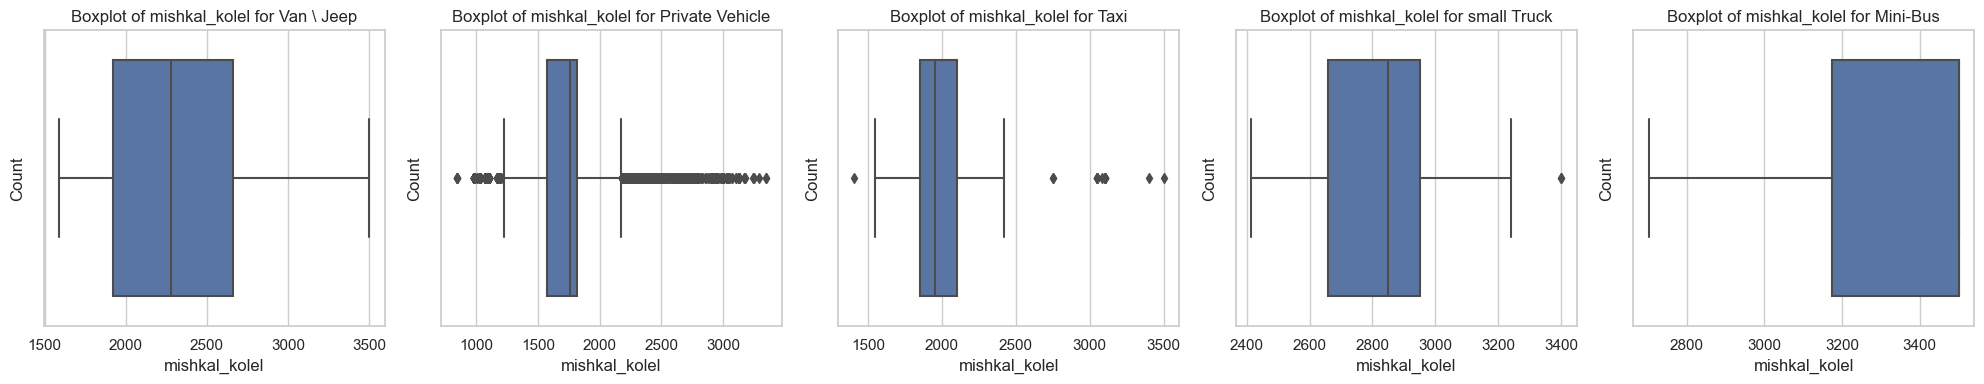

In [69]:
def plot_boxplots_by_category(data, category_column, value_column):
    sns.set(style="whitegrid")
    categories = data[category_column].unique()
    num_categories = len(categories)
    num_cols = 5
    num_rows = (num_categories + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))  # Adjusted the figure size
    axes = axes.flatten()  # Flatten the axes array for easier indexing
    for i in range(num_rows * num_cols):
        if i < num_categories:
            category = categories[i]
            sns.boxplot(x=value_column, data=data[data[category_column] == category], ax=axes[i])
            axes[i].set_title(f'Boxplot of {value_column} for {category}')
            axes[i].set_xlabel(value_column)
            axes[i].set_ylabel('Count')
        else:
            axes[i].set_visible(False)
            
    plt.tight_layout()
    plt.show()

plot_boxplots_by_category(df, 'vehicle_category', 'mishkal_kolel')

In [70]:
df.loc[(df['vehicle_category'] == 'Private Vehicle') & (df['mishkal_kolel'] >= 2600), 'vehicle_category'] = 'Van \\ Jeep'

In [71]:
models_to_replace = ['C200 D', 'COROLLA','CIVIC', 'KANGOO','COOPER S','ACCENT','Q3',"וולבו בלגיה 4דל'ES07",'C200CDI','MOKKA','LEXUS CT200H','MAZDA 3','MEGANE II','COROLLA RUNX','INSIGNIA','MALIBU LT','I30','ACCORD','CADDY','LANCER','LARGO','CEED','JUMPY','TOURNEO CONNECT','MONDEO','MEGANE','OPTRA','IMPALA','A4']
df.loc[df['kinuy_mishari'].isin(models_to_replace), 'mishkal_kolel'] = 1500
df.loc[df['kinuy_mishari'].isin(models_to_replace), 'vehicle_category'] = 'Private Vehicle'

models_to_replace2 = ['CARNIVAL']
df.loc[df['kinuy_mishari'].isin(models_to_replace2), 'mishkal_kolel'] = 2084

models_to_replace3 = ['EDGE','Q5','CARNIVAL','RODIUS','TOWN COUNTRY','CAYENNE TURBO','CAYENNE','EXPLORER','TIGGO 8 PRO','GRAND CHEROKEE','JEEP COMPASS','RENGE ROVER']
df.loc[df['kinuy_mishari'].isin(models_to_replace3), 'vehicle_category'] = 'Van \\ Jeep'

models_to_replace4 = ['IMPREZA NEW','A3', 'PUNT0 60','307','FOCUS','CRUZE', 'GOLF','ASTRA ST','FLUENCE','ASTRA','OCTAVIA','ALMERA','IMPREZA','RIO','IBIZA','JETTA','CORSA-C']
df.loc[df['kinuy_mishari'].isin(models_to_replace4), 'mishkal_kolel'] = 1300
df.loc[df['kinuy_mishari'].isin(models_to_replace4), 'vehicle_category'] = 'Private Vehicle'

models_to_replace5 = ['S60','S80']
df.loc[df['kinuy_mishari'].isin(models_to_replace5), 'mishkal_kolel'] = 1700
df.loc[df['kinuy_mishari'].isin(models_to_replace5), 'vehicle_category'] = 'Private Vehicle'

models_to_replace6 = ['AVEO','GETZ','MAZDA 2','PUNTO 16V','POLO','ליאנה','LIANA']
df.loc[df['kinuy_mishari'].isin(models_to_replace6), 'mishkal_kolel'] = 1100
df.loc[df['kinuy_mishari'].isin(models_to_replace6), 'vehicle_category'] = 'Mini Private Vehicle'


filtered_rows = df.loc[(df['vehicle_category'] == 'Van \\ Jeep') & (df['mishkal_kolel'] > 5000)]
df = df.drop(filtered_rows.index)

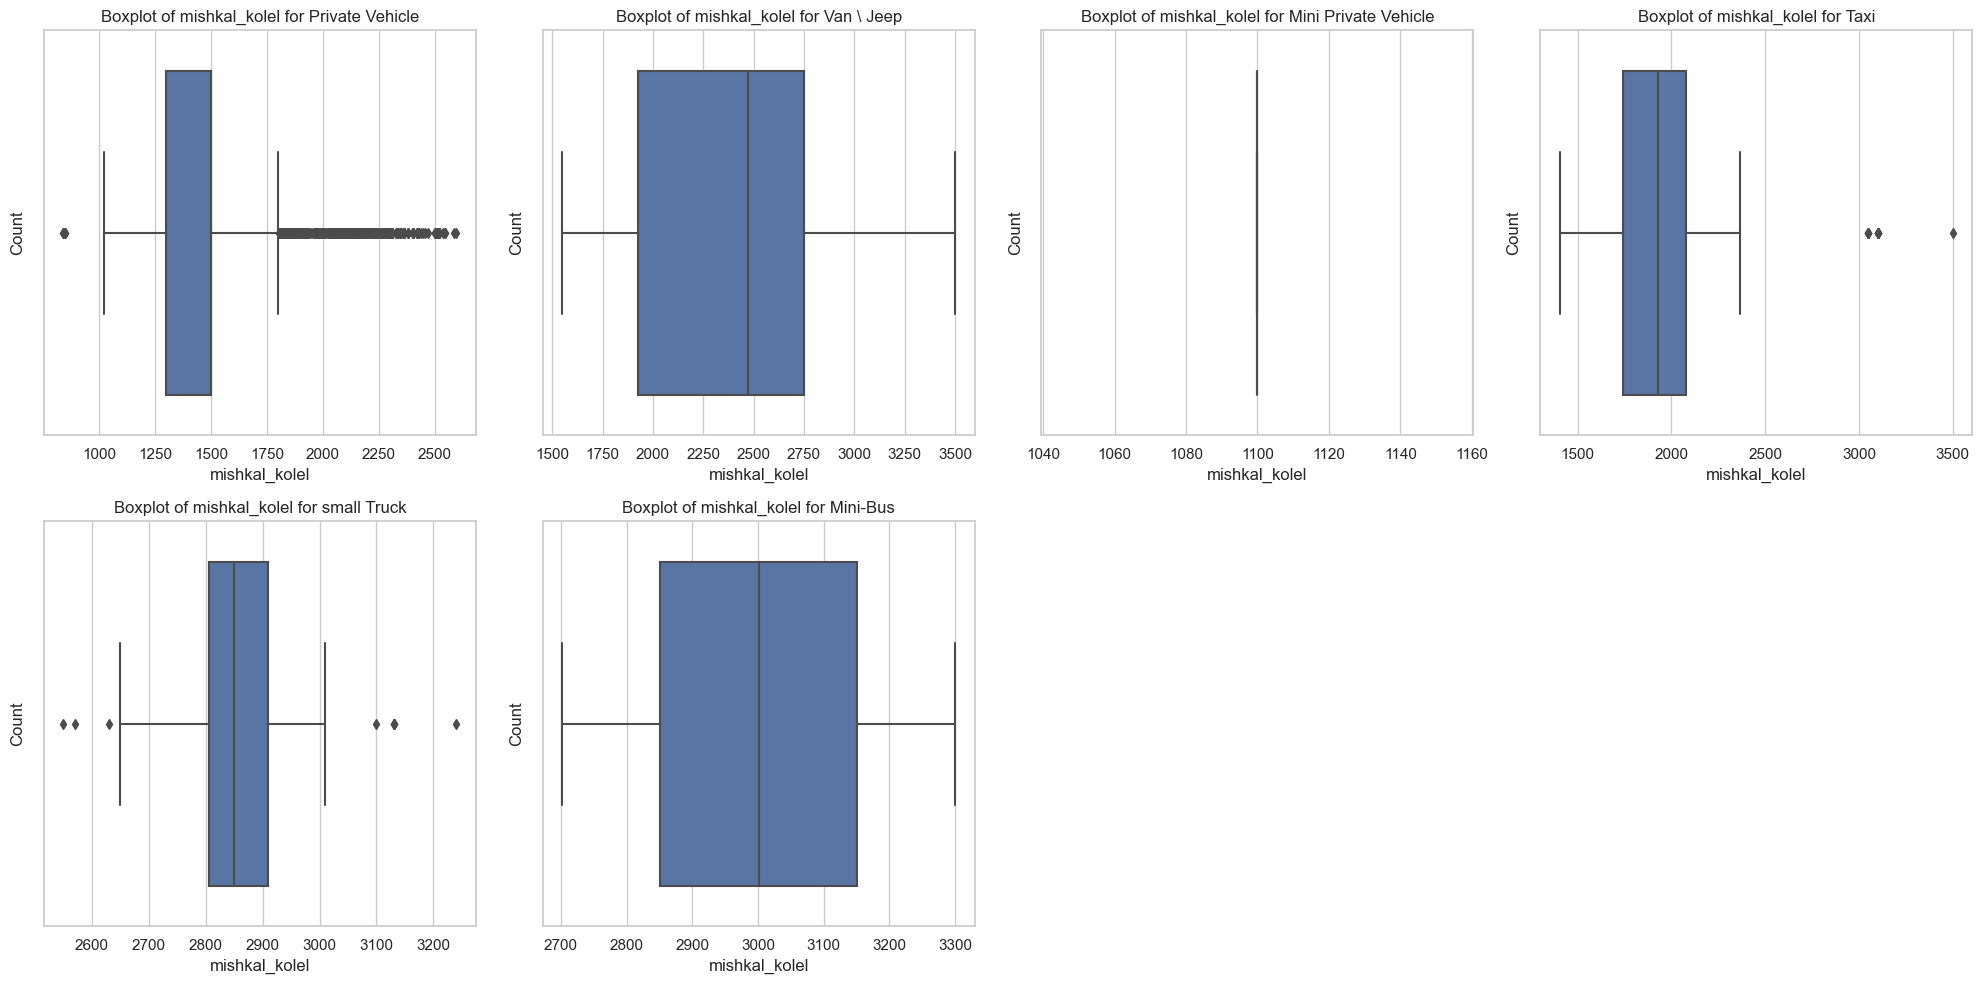

In [72]:
def plot_boxplots_by_category(data, category_column, value_column):
    sns.set(style="whitegrid")
    categories = data[category_column].unique()
    num_categories = len(categories)
    num_cols = 4  
    num_rows = (num_categories + num_cols - 1) // num_cols  
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))  
    axes = axes.flatten()  
    # Plot a boxplot for each category
    for i, category in enumerate(categories):
        sns.boxplot(x=value_column, data=data[data[category_column] == category], ax=axes[i])
        axes[i].set_title(f'Boxplot of {value_column} for {category}')
        axes[i].set_xlabel(value_column)
        axes[i].set_ylabel('Count')
    
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

plot_boxplots_by_category(df, 'vehicle_category', 'mishkal_kolel')

### using binary encoder

In [73]:
columns_to_encode = ['tozeret_nm', 'degem_nm',
                     'tozar_manoa', 'degem_manoa',
                     'ramat_gimur', 'baalut', 'tzeva_rechev',
                     'zmig_kidmi', 'sug_delek_nm',
                     'kinuy_mishari', 'vehicle_category']

numerical_cols = ['bitul_year', 'bitul_month', 'mishkal_kolel', 'ramat_eivzur_betihuty',
                  'kvutzat_zihum', 'shnat_yitzur_and_aliya_lakvish', 'horaat_rishum']


preprocessing = ColumnTransformer(
     transformers=[
         ('BinaryEncoder', ce.BinaryEncoder(cols=columns_to_encode), columns_to_encode),
         ('scaling', StandardScaler(), numerical_cols)
     ])


encoding_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing)
])

encoded_df = encoding_pipeline.fit_transform(df)
encoded_df= pd.DataFrame(encoded_df)

/Users/yogevladani/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/gw/_gx47l1n2cb_95xxx6f5632h0000gn/T/ipykernel_53873/2776692661.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


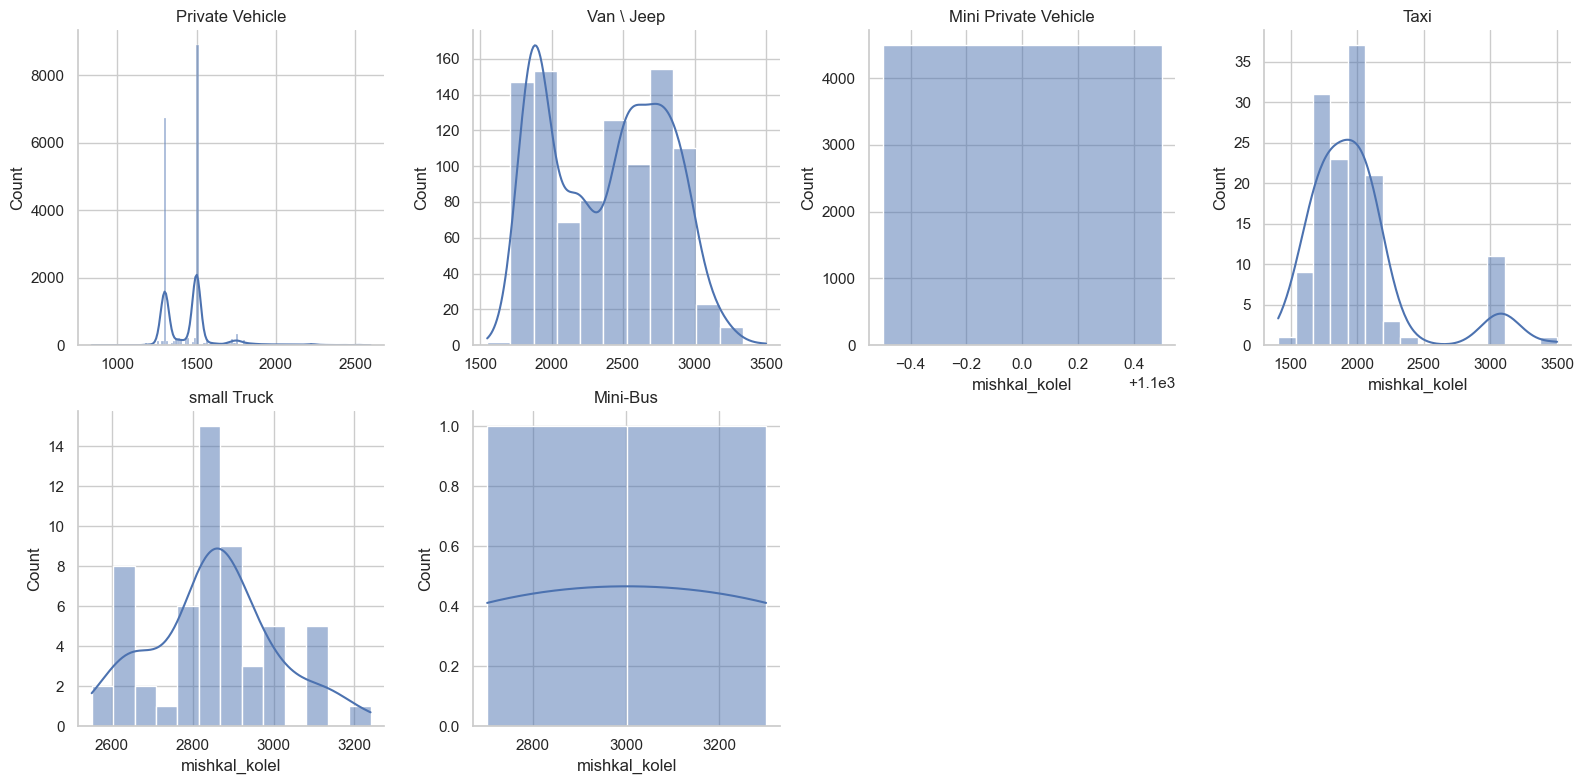

In [74]:
def hist_plots(df,group_column,target_column):
    df[f'{group_column}_hebrew_fixed'] = df[group_column].apply(lambda x: get_display(arabic_reshaper.reshape(x))).copy()
    n = len(df[f'{group_column}_hebrew_fixed'].unique())
    ncols = 4  
    nrows = n // ncols + (n % ncols > 0)
    g = sns.FacetGrid(df, col=f'{group_column}_hebrew_fixed', col_wrap=ncols, sharex=False, sharey=False, height=4)
    g.map(sns.histplot, target_column, kde=True)
    for ax, title in zip(g.axes.flatten(), df[f'{group_column}_hebrew_fixed'].unique()):
        ax.set_title(title)
    plt.tight_layout()
    plt.show()
hist_plots(df=df,group_column='vehicle_category',target_column='mishkal_kolel')

/Users/yogevladani/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/gw/_gx47l1n2cb_95xxx6f5632h0000gn/T/ipykernel_53873/2776692661.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


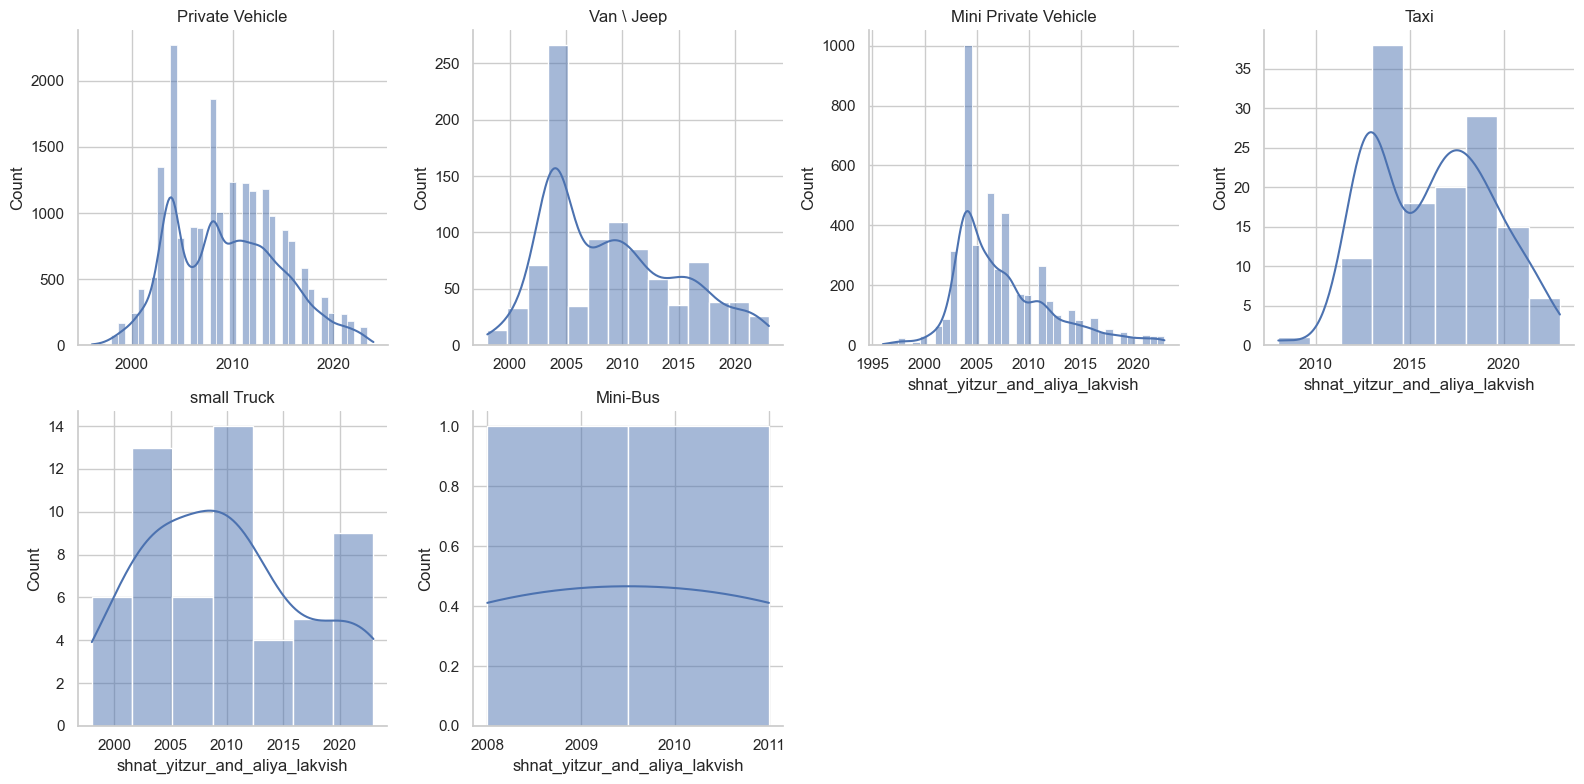

In [75]:
hist_plots(df=df,group_column='vehicle_category',target_column='shnat_yitzur_and_aliya_lakvish')

### The data is not normally distributed, we will not use Z Score but isolation forest

In [76]:
def detect_outliers_isolation_forest(data, contamination=0.1):
    isolation_forest = IsolationForest(contamination=contamination)
    outliers = isolation_forest.fit_predict(data)
    outlier_indices = [i for i, outlier in enumerate(outliers) if outlier == -1]
    return outlier_indices

outlier_indices = detect_outliers_isolation_forest(encoded_df)
print("Indices of outliers detected by Isolation Forest:", len(outlier_indices))

Indices of outliers detected by Isolation Forest: 2581


In [77]:
def remove_outliers(data, outlier_indices):
    cleaned_data = data.drop(index=outlier_indices).reset_index(drop=True)
    return cleaned_data

cleaned_data = remove_outliers(encoded_df, outlier_indices)


# ---------------------------------------------------------------------------------------------

## **Dimensionality Reduction**

## <blockquote>Try  PCA</blockquote>


In [78]:
full_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('pca', PCA(n_components=0.9))])

X_transformed = full_pipeline.fit_transform(df)
pca_model = full_pipeline.named_steps['pca']

preprocessed_feature_names = numerical_cols  # Adjust this line if necessary

explained_variance_ratio = pca_model.explained_variance_ratio_

var = 0
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Explained Variance Ratio for Dimension {i+1}: {ratio:.4f}")
    var += ratio

print("Total Variance Explained: {:.2f}".format(var))

Explained Variance Ratio for Dimension 1: 0.1222
Explained Variance Ratio for Dimension 2: 0.0587
Explained Variance Ratio for Dimension 3: 0.0555
Explained Variance Ratio for Dimension 4: 0.0494
Explained Variance Ratio for Dimension 5: 0.0370
Explained Variance Ratio for Dimension 6: 0.0323
Explained Variance Ratio for Dimension 7: 0.0291
Explained Variance Ratio for Dimension 8: 0.0275
Explained Variance Ratio for Dimension 9: 0.0237
Explained Variance Ratio for Dimension 10: 0.0221
Explained Variance Ratio for Dimension 11: 0.0214
Explained Variance Ratio for Dimension 12: 0.0194
Explained Variance Ratio for Dimension 13: 0.0184
Explained Variance Ratio for Dimension 14: 0.0174
Explained Variance Ratio for Dimension 15: 0.0168
Explained Variance Ratio for Dimension 16: 0.0162
Explained Variance Ratio for Dimension 17: 0.0154
Explained Variance Ratio for Dimension 18: 0.0149
Explained Variance Ratio for Dimension 19: 0.0147
Explained Variance Ratio for Dimension 20: 0.0138
Explained

## we will use scaled inertia to find the best K.

### Mathematical and theoretical explanation:
### <blockquote>https://towardsdatascience.com/an-approach-for-choosing-number-of-clusters-for-k-means-c28e614ecb2c</blockquote>

In [79]:
def kMeansRes(scaled_data, k, alpha_k):
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia

def chooseBestKforKMeans(scaled_data, k_range, alpha_k=0.02):
    ans = []
    for k in k_range:
        scaled_inertia = kMeansRes(scaled_data, k, alpha_k)
        ans.append((k, scaled_inertia))
    results = pd.DataFrame(ans, columns=['k', 'Scaled Inertia']).set_index('k')
    return results

def cluster_and_evaluate(data, cluster_range=[2, 3, 4, 5, 6, 7, 8]):
    scaled_data = np.asarray(data).astype(float)
    Scaled_Inertia_df = chooseBestKforKMeans(scaled_data, cluster_range, 0.02)
    results_df = pd.DataFrame(columns=['Clusters', 'SSE','Scaled Inertia','Silhouette', 'Sample Count', 'Min Count', 'Max Count'])

    for num_clusters in cluster_range:
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10).fit(data)

        labels = kmeans.labels_
        sample_count = pd.Series(labels).value_counts()
        
        scaled_inertia = kMeansRes(scaled_data, num_clusters, 0.02)

        sse = kmeans.inertia_
        silhouette_avg = silhouette_score(data, labels)
        
        results_df = pd.concat([results_df, pd.DataFrame({'Clusters': [num_clusters], 'SSE': [sse],'Scaled Inertia' : [scaled_inertia], 'Silhouette': [silhouette_avg], 'Sample Count': [sample_count], 'Min Count': [sample_count.min()], 'Max Count': [sample_count.max()]})], ignore_index=True)
    

    plt.figure(figsize=(7, 4))
    plt.plot(Scaled_Inertia_df, 'o')
    plt.title('Scaled Inertia for each K')
    plt.xlabel('K')
    plt.ylabel('Scaled Inertia')
    plt.xticks(range(2, 10))
    plt.show()
    
    return results_df

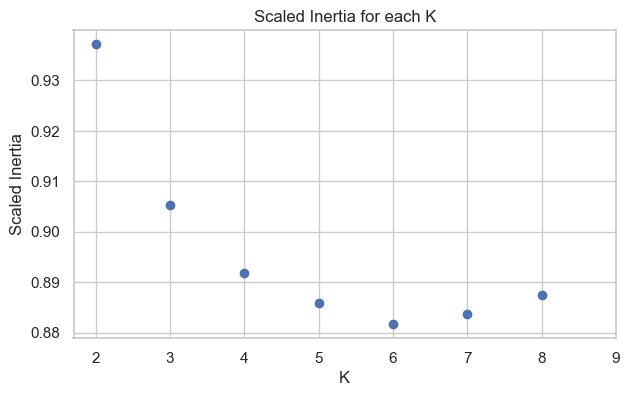

,Clusters,SSE,Scaled Inertia,Silhouette,Sample Count,Min Count,Max Count
0,2,457970.309266,0.937174,0.098144,"1 14556 0 11247 Name: count, dtype: int64",11247,14556
1,3,431534.731745,0.905386,0.103463,"1 13628 0 11205 2 970 Name: count, ...",970,13628
2,4,414383.980257,0.891787,0.076808,0 11147 3 7013 1 6706 2 937 Na...,937,11147
3,5,401182.556806,0.885925,0.073429,4 7667 1 6699 0 6620 2 3880 3 ...,937,7667
4,6,388818.394530,0.881703,0.076528,0 7383 5 6272 4 6202 1 3738 2 1...,913,7383
5,7,379639.930903,0.883723,0.076236,4 6265 2 6198 1 5610 3 3191 6 2...,913,6265
6,8,371371.983374,0.887526,0.069851,0 6188 4 5647 7 5396 2 3231 1 1...,915,6188


In [80]:
results = cluster_and_evaluate(X_transformed)
results

In [81]:
kmeans_orig = KMeans(n_clusters=5, random_state=42)
labels_orig = kmeans_orig.fit_predict(encoded_df)

kmeans_pca = KMeans(n_clusters=5, random_state=42)
labels_pca = kmeans_pca.fit_predict(X_transformed)

silhouette_orig = silhouette_score(encoded_df, labels_orig)
silhouette_pca = silhouette_score(X_transformed, labels_pca)

print("Silhouette Score for Original Data:", silhouette_orig)
print("Silhouette Score for PCA-transformed Data:", silhouette_pca)

/Users/yogevladani/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yogevladani/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for Original Data: 0.06439540352978457
Silhouette Score for PCA-transformed Data: 0.07342877170975079


### We showed that the silhouette value did not change negatively in the state before Physiai, so that actually by using Physiai we did not reduce the quality of the data

## Because the silhouette is really low, the optimal K is chosen according to the scaled inertia

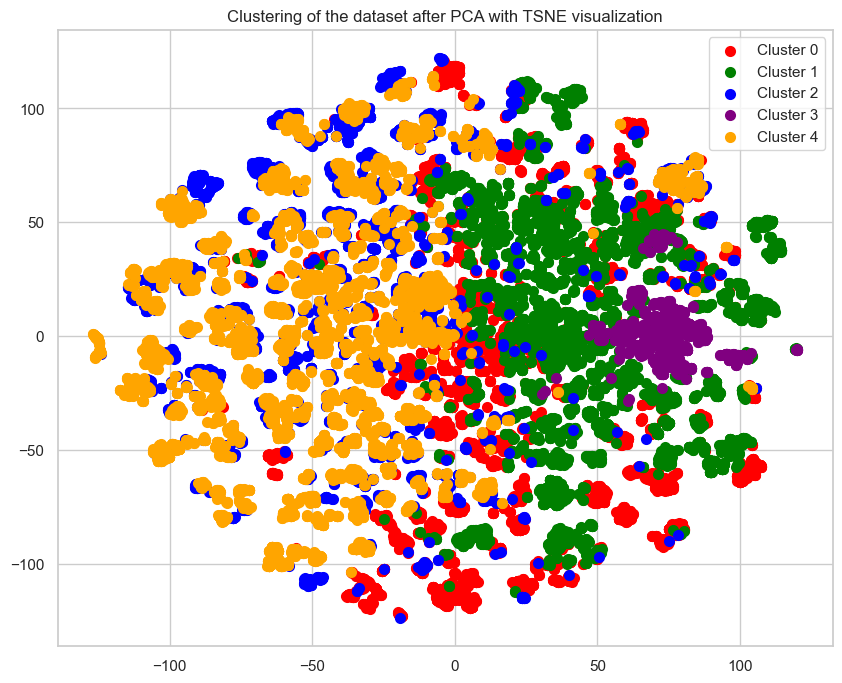

In [82]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_transformed)

colors = ['red', 'green', 'blue', 'purple', 'orange']
plt.figure(figsize=(10, 8))
for i, color in enumerate(colors[:6]): 
    plt.scatter(X_tsne[labels_pca == i, 0], X_tsne[labels_pca == i, 1], color=color, lw=2, label=f'Cluster {i}')
plt.title('Clustering of the dataset after PCA with TSNE visualization')
plt.legend()
plt.show()

In [83]:
df['cluster_labels']=labels_pca
df.head()

,tozeret_nm,degem_nm,sug_rechev_nm,tozar_manoa,degem_manoa,mishkal_kolel,ramat_gimur,ramat_eivzur_betihuty,kvutzat_zihum,shnat_yitzur_and_aliya_lakvish,...,zmig_kidmi,zmig_ahori,sug_delek_nm,horaat_rishum,kinuy_mishari,bitul_year,bitul_month,vehicle_category,vehicle_category_hebrew_fixed,cluster_labels
0,פולקסווגן גרמנ,7EMH49,מרכב אחוד,פולקסוגן גרמני,CFC,1300,MULTIVAN,0,15,2012,...,255/45 R18,255/45 R18,diesel,120191,GOLF,2019,6,Private Vehicle,Private Vehicle,1
1,פורד תורכיה,PT2,מרכב אחוד,טורקיה פורד,KKDA,1500,S,0,15,2012,...,195/65R15,195/65R15,diesel,121663,TOURNEO CONNECT,2019,5,Private Vehicle,Private Vehicle,1
2,פיאט תורכיה,263WXC1A,מרכב אחוד,פיאט,263A2000,2090,TOP BASE,0,15,2012,...,195/65R15,195/65R15,diesel,0,DOBLO,2019,2,Van \ Jeep,Van \ Jeep,0
3,קיה קוריאה,JC5248,מרכב אחוד,יונדאי,D4CB,2850,EX,0,0,2008,...,245/70R16,245/70R16,diesel,0,PICANTO,2019,12,Van \ Jeep,Van \ Jeep,2
4,קיה קוריאה,MB7543,מרכב אחוד,קאיה,J3,2920,LX,0,0,2007,...,225/70R16,225/70R16,diesel,0,PICANTO,2020,3,Van \ Jeep,Van \ Jeep,2


### Try to reduce dimensions with PCA 
#### Over 90% of the variation is explained using 50-55 features
#### On the one hand, we managed to reduce dimensions, but not enough. We will test the effectiveness of dimensionality reduction using clustering on the data before and after
#### The PCA did not significantly change the cluster structure of the data. This could mean that the original high-dimensional space contained redundant or irrelevant features, and the retained principal components captured most of the variance that was relevant to clustering.
#### On the other hand, it seems that in this situation there are almost no defined clusters in the data.

## <blockquote>Try Karnel PCA</blockquote>


In [84]:
kpca = KernelPCA(n_components=2, kernel='sigmoid', gamma=10)
X_kpca = kpca.fit_transform(encoded_df)


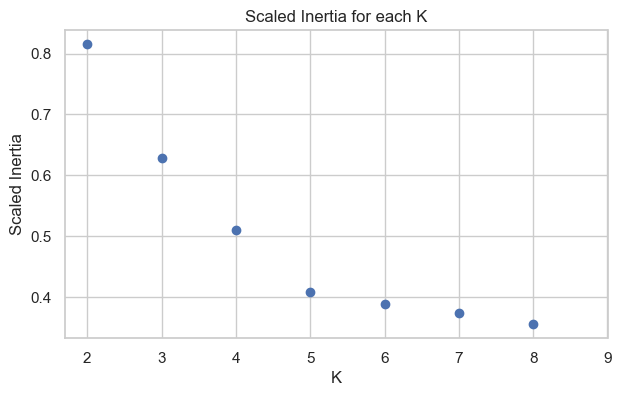

,Clusters,SSE,Scaled Inertia,Silhouette,Sample Count,Min Count,Max Count
0,2,403.695977,0.815261,0.730984,"0 23794 1 2009 Name: count, dtype: int64",2009,23794
1,3,296.142224,0.628714,0.743264,"1 23751 2 1993 0 59 Name: count, ...",59,23751
2,4,224.151946,0.510463,0.757960,0 23604 2 1989 1 152 3 58 Na...,58,23604
3,5,160.960112,0.409109,0.778639,0 23244 3 1980 2 369 1 152 4 ...,58,23244
4,6,139.679139,0.388241,0.781289,0 23215 1 1978 4 369 3 150 5 ...,23,23215
5,7,121.403544,0.373144,0.703609,0 22415 6 1892 1 890 3 369 4 ...,18,22415
6,8,101.760072,0.355421,0.714166,1 21571 5 1855 7 1095 0 884 4 ...,18,21571


In [85]:
results_K = cluster_and_evaluate(X_kpca)
results_K

In [86]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_kpca)
df['cluster_labels_karnel'] = clusters

silhouette_kernel_pca = silhouette_score(X_kpca, clusters)

print("Silhouette Score for Kernel PCA:", silhouette_kernel_pca)



/Users/yogevladani/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for Kernel PCA: 0.7309839902576687


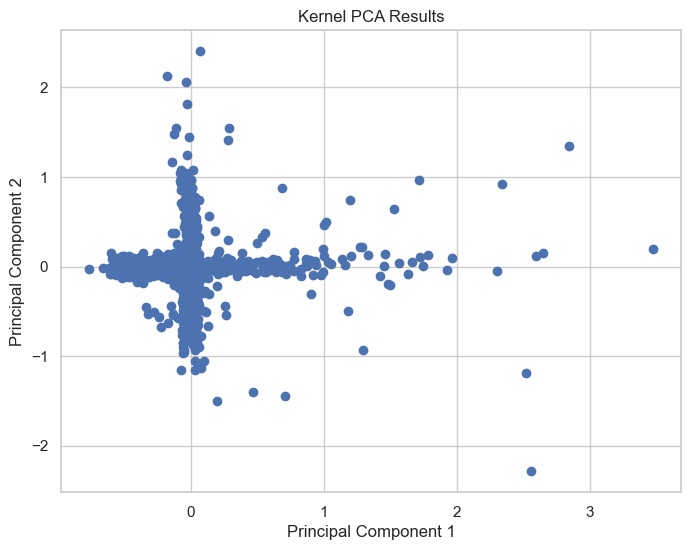

In [87]:
plt.figure(figsize=(8, 6))
plt.scatter(X_kpca[:, 0], X_kpca[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Kernel PCA Results')
plt.show()

/Users/yogevladani/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


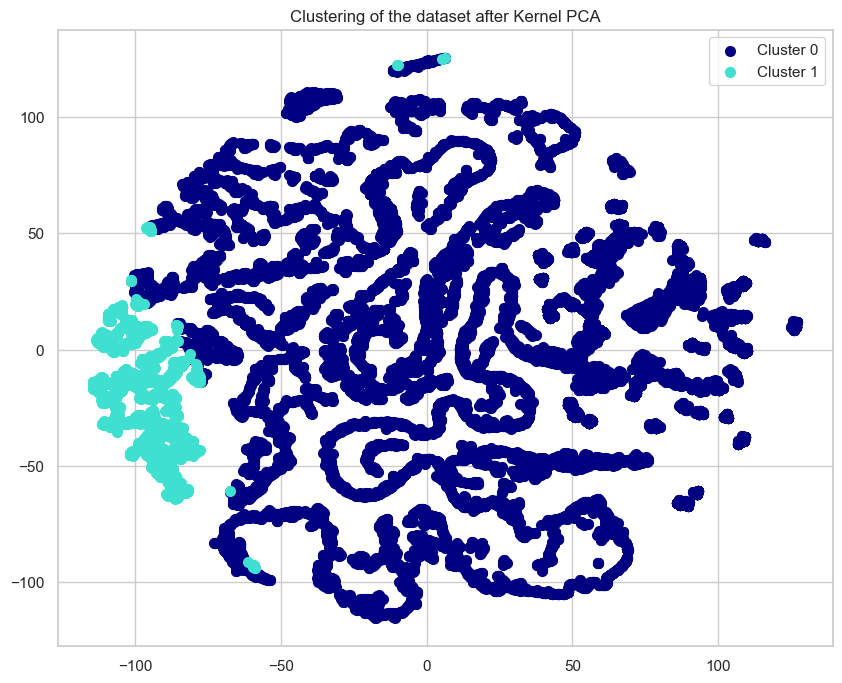

In [88]:
k = 2
colors = ['navy', 'turquoise', 'darkorange', 'red', 'purple'] 
kmeans = KMeans(n_clusters=k, random_state=42)

clusters = kmeans.fit_predict(X_kpca)
df['cluster_labels_karnel'] = clusters
tsne = TSNE(n_components=2, random_state=42)

X_tsne = tsne.fit_transform(X_kpca)

plt.figure(figsize=(10, 8))
for i, color in zip(range(k), colors):
    plt.scatter(X_tsne[clusters == i, 0], X_tsne[clusters == i, 1], color=color, lw=2, label=f'Cluster {i}')
plt.title('Clustering of the dataset after Kernel PCA')
plt.legend()
plt.show()

### We will note that even with scaled inertia there is no convergence to an optimal value, therefore we tested several options with TSNE and saw that 2 clusters come out the most defined without exceptions and too much mixing.

# --------------------------------------------------------------------------

## **Hierarchical Clustering**

### We used hierarchical trees to support our argument that the data is split into two clusters. We wanted to examine the data without creating a bias and in addition to minimize the variation therefore we used Wards Linkage.


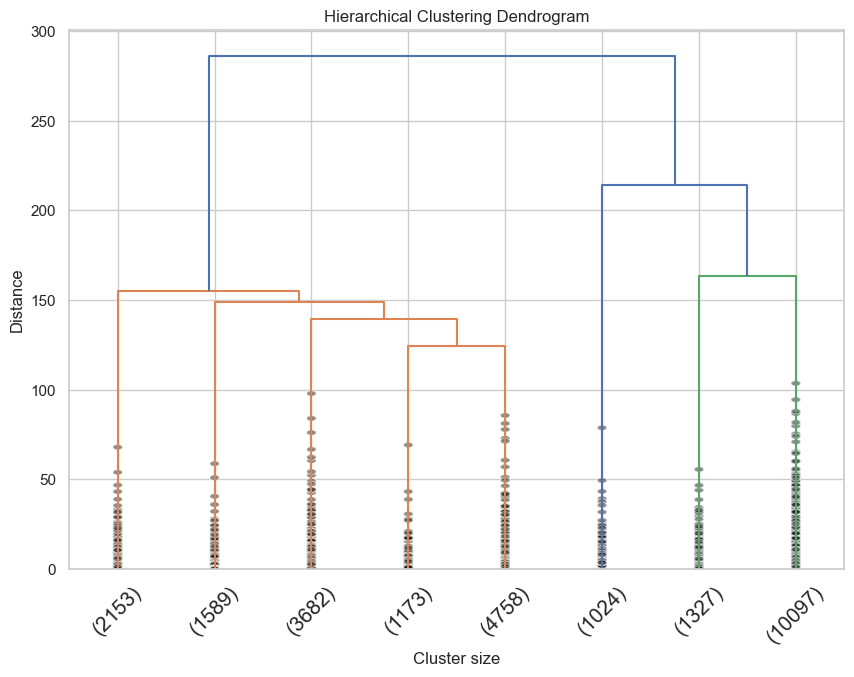

In [89]:
Z = linkage(encoded_df, 'ward')  

plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(Z, truncate_mode='lastp',p=8, leaf_rotation=45., leaf_font_size=15., show_contracted=True)
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()


### it can be seen that there is a large vertical distance between the division and 2 clusters in contrast to the divisions that come after that show a less distinct separation (smaller vertical distance). Therefore, it can be said that the hierarchical trees also contribute to our claim that there are 2 distinct clusters in the data.

# ---------------------------------------------------------------------------------------------

## Results and discussion

### We extracted a representation for all categorical columns and all numeric columns in each cluster to examine the data.

In [90]:
categorical_cols = ['tozeret_nm','vehicle_category', 'tozar_manoa','tzeva_rechev','sug_delek_nm']  

In [91]:
def reshape_hebrew(text):
    reshaped_text = arabic_reshaper.reshape(text)
    return get_display(reshaped_text)

def analyze_categorical(df, cluster_col, cat_cols, frequency_threshold=80):
    clusters = df[cluster_col].unique()
    for cat_col in cat_cols:
        # Determine global frequency to keep consistent categories
        global_freq = df[cat_col].value_counts()
        categories_to_keep = global_freq[global_freq >= frequency_threshold].index
        
        for cluster in clusters:
            cluster_df = df[df[cluster_col] == cluster]
            # Calculate frequency within cluster for categories to keep
            cluster_freq = cluster_df[cat_col].value_counts()
            cluster_categories_to_keep = cluster_freq.index.intersection(categories_to_keep)
            cluster_freq_percent = cluster_freq[cluster_categories_to_keep] / cluster_freq[cluster_categories_to_keep].sum() * 100
            
            if not cluster_freq_percent.empty:
                plt.figure(figsize=(25, 10))
                ax = sns.barplot(x=cluster_freq_percent.index, y=cluster_freq_percent.values, palette='viridis')
                hebrew_labels = [reshape_hebrew(label) for label in cluster_freq_percent.index]
                ax.set_xticklabels(hebrew_labels, rotation=90, ha="right")
                ax.set_title(reshape_hebrew(f'Cluster {cluster} - {cat_col}'), fontsize=22)
                ax.set_xlabel(reshape_hebrew(cat_col), fontsize=20)
                ax.set_ylabel(reshape_hebrew('percentage'), fontsize=20)
                ax.tick_params(axis='both', which='major', labelsize=18)
                plt.tight_layout()
                plt.show()

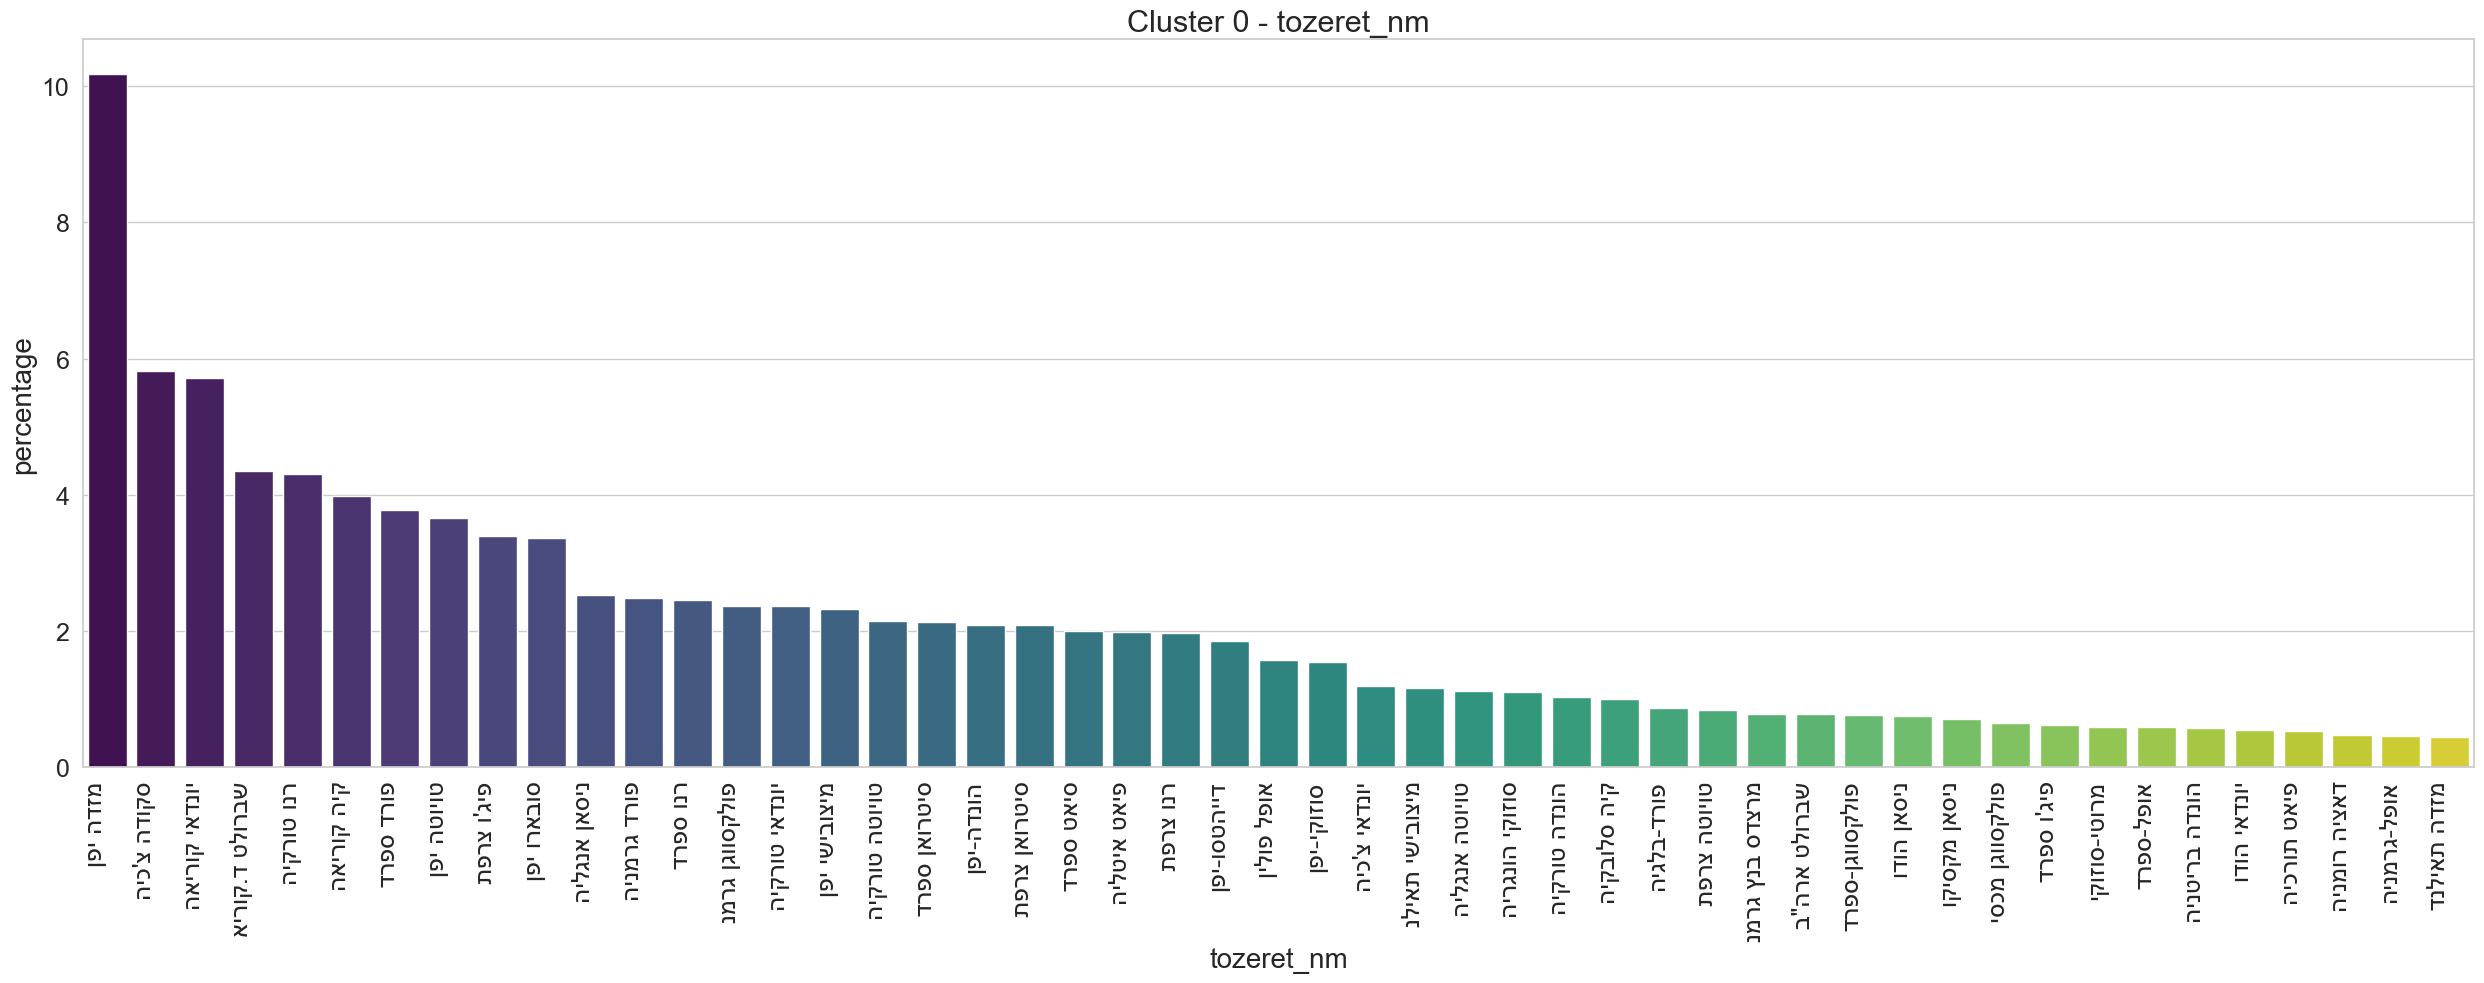

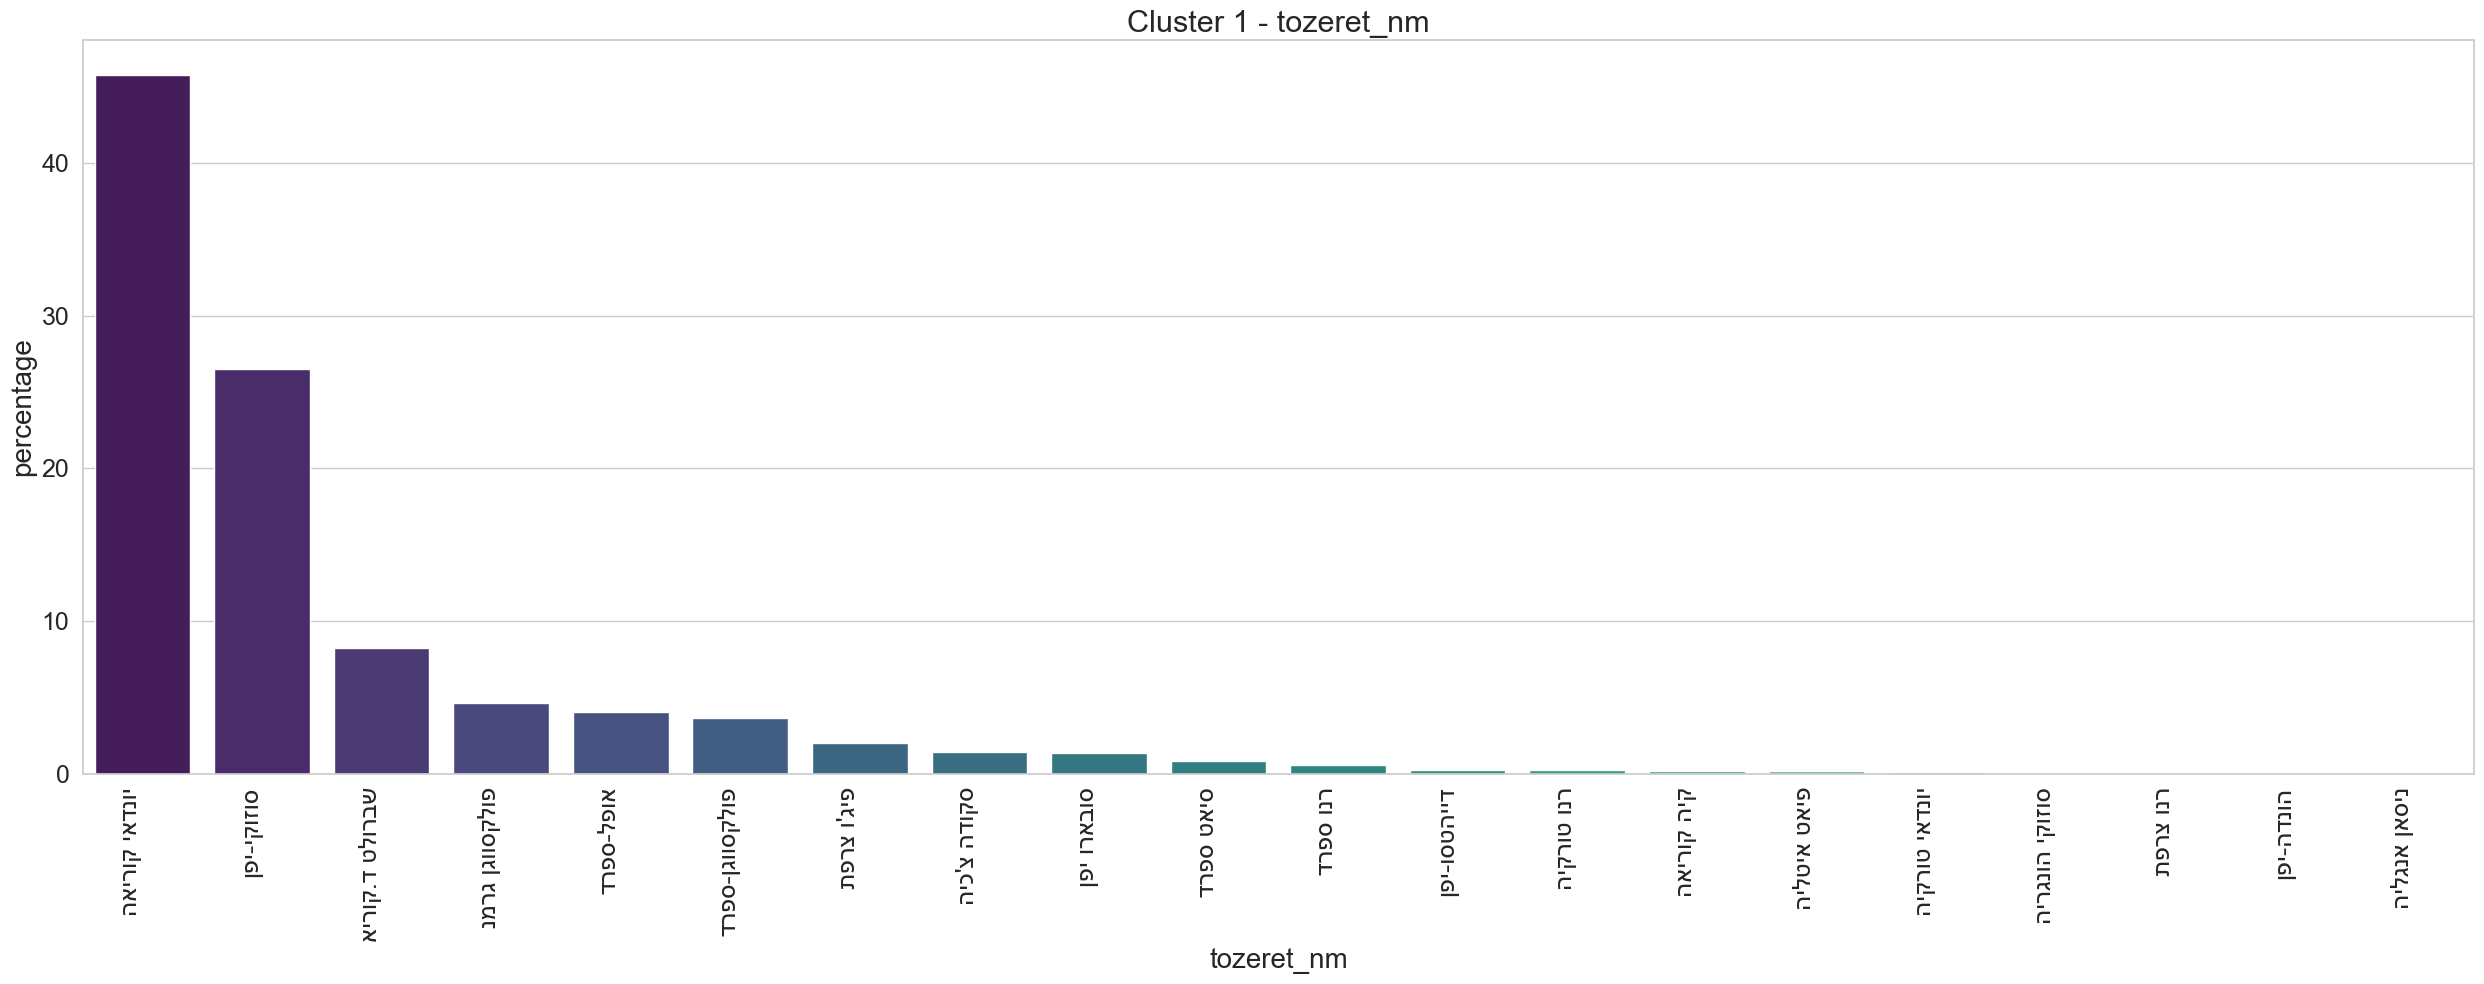

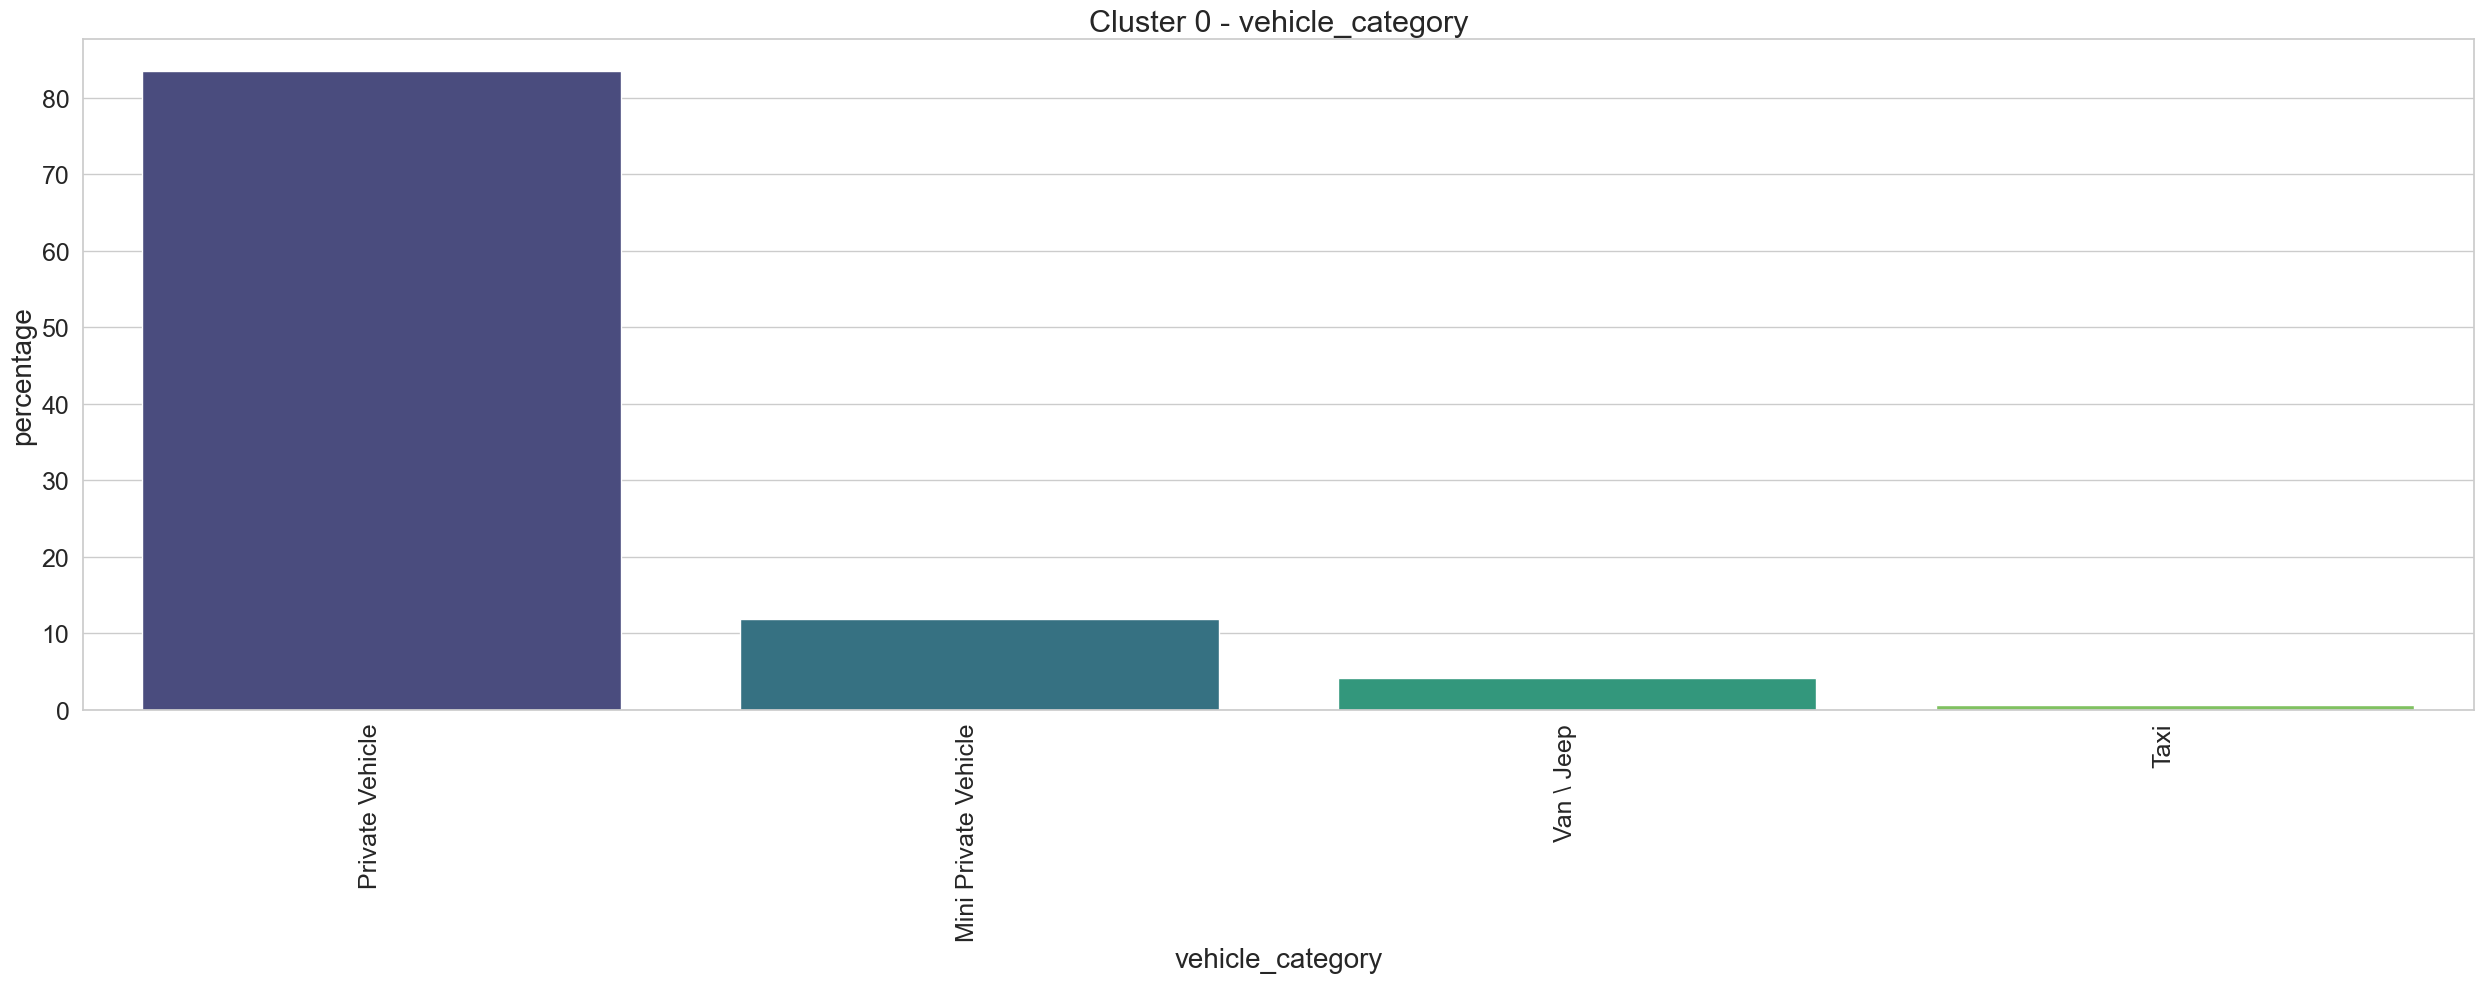

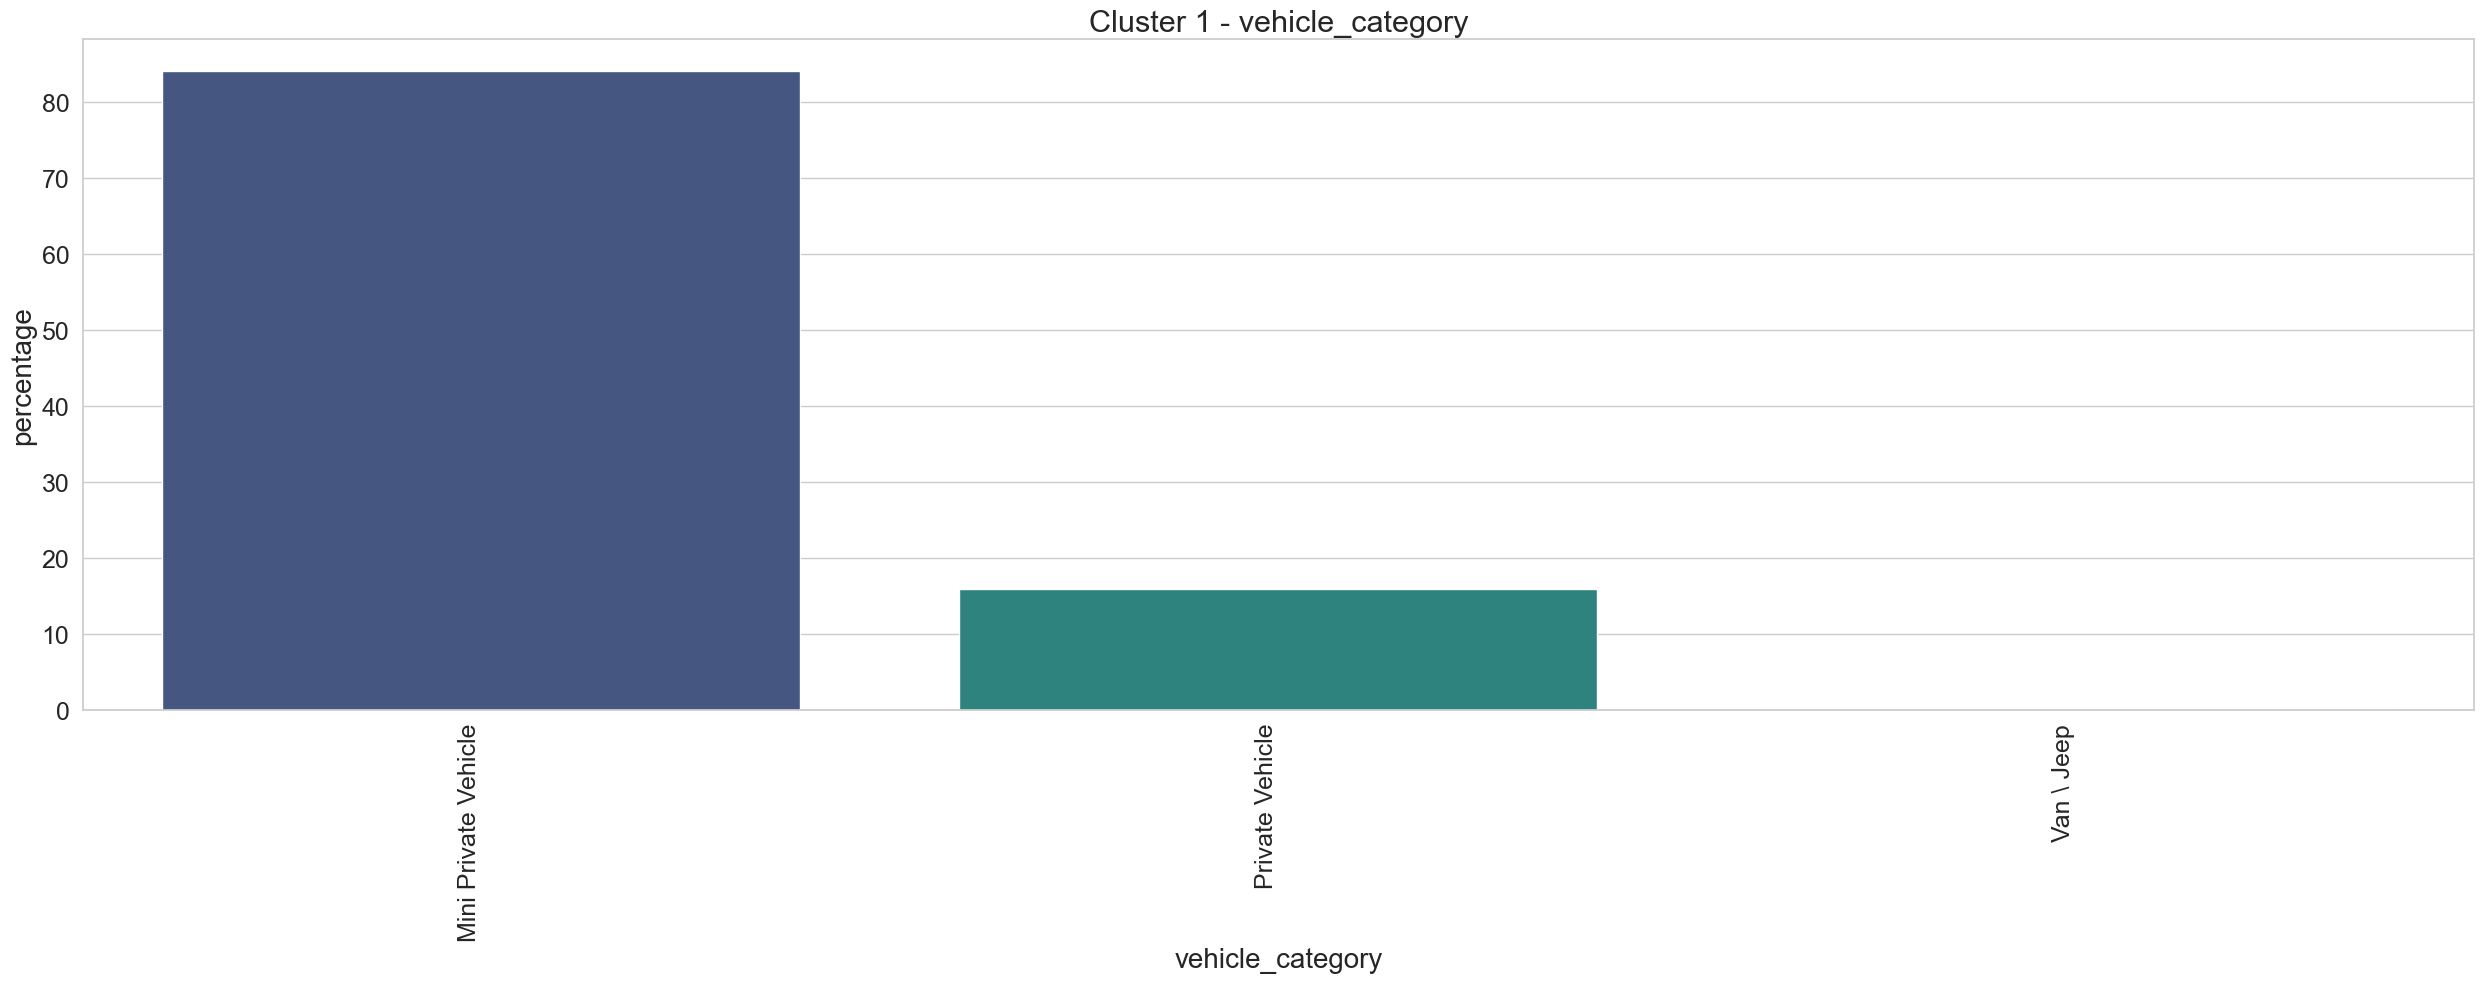

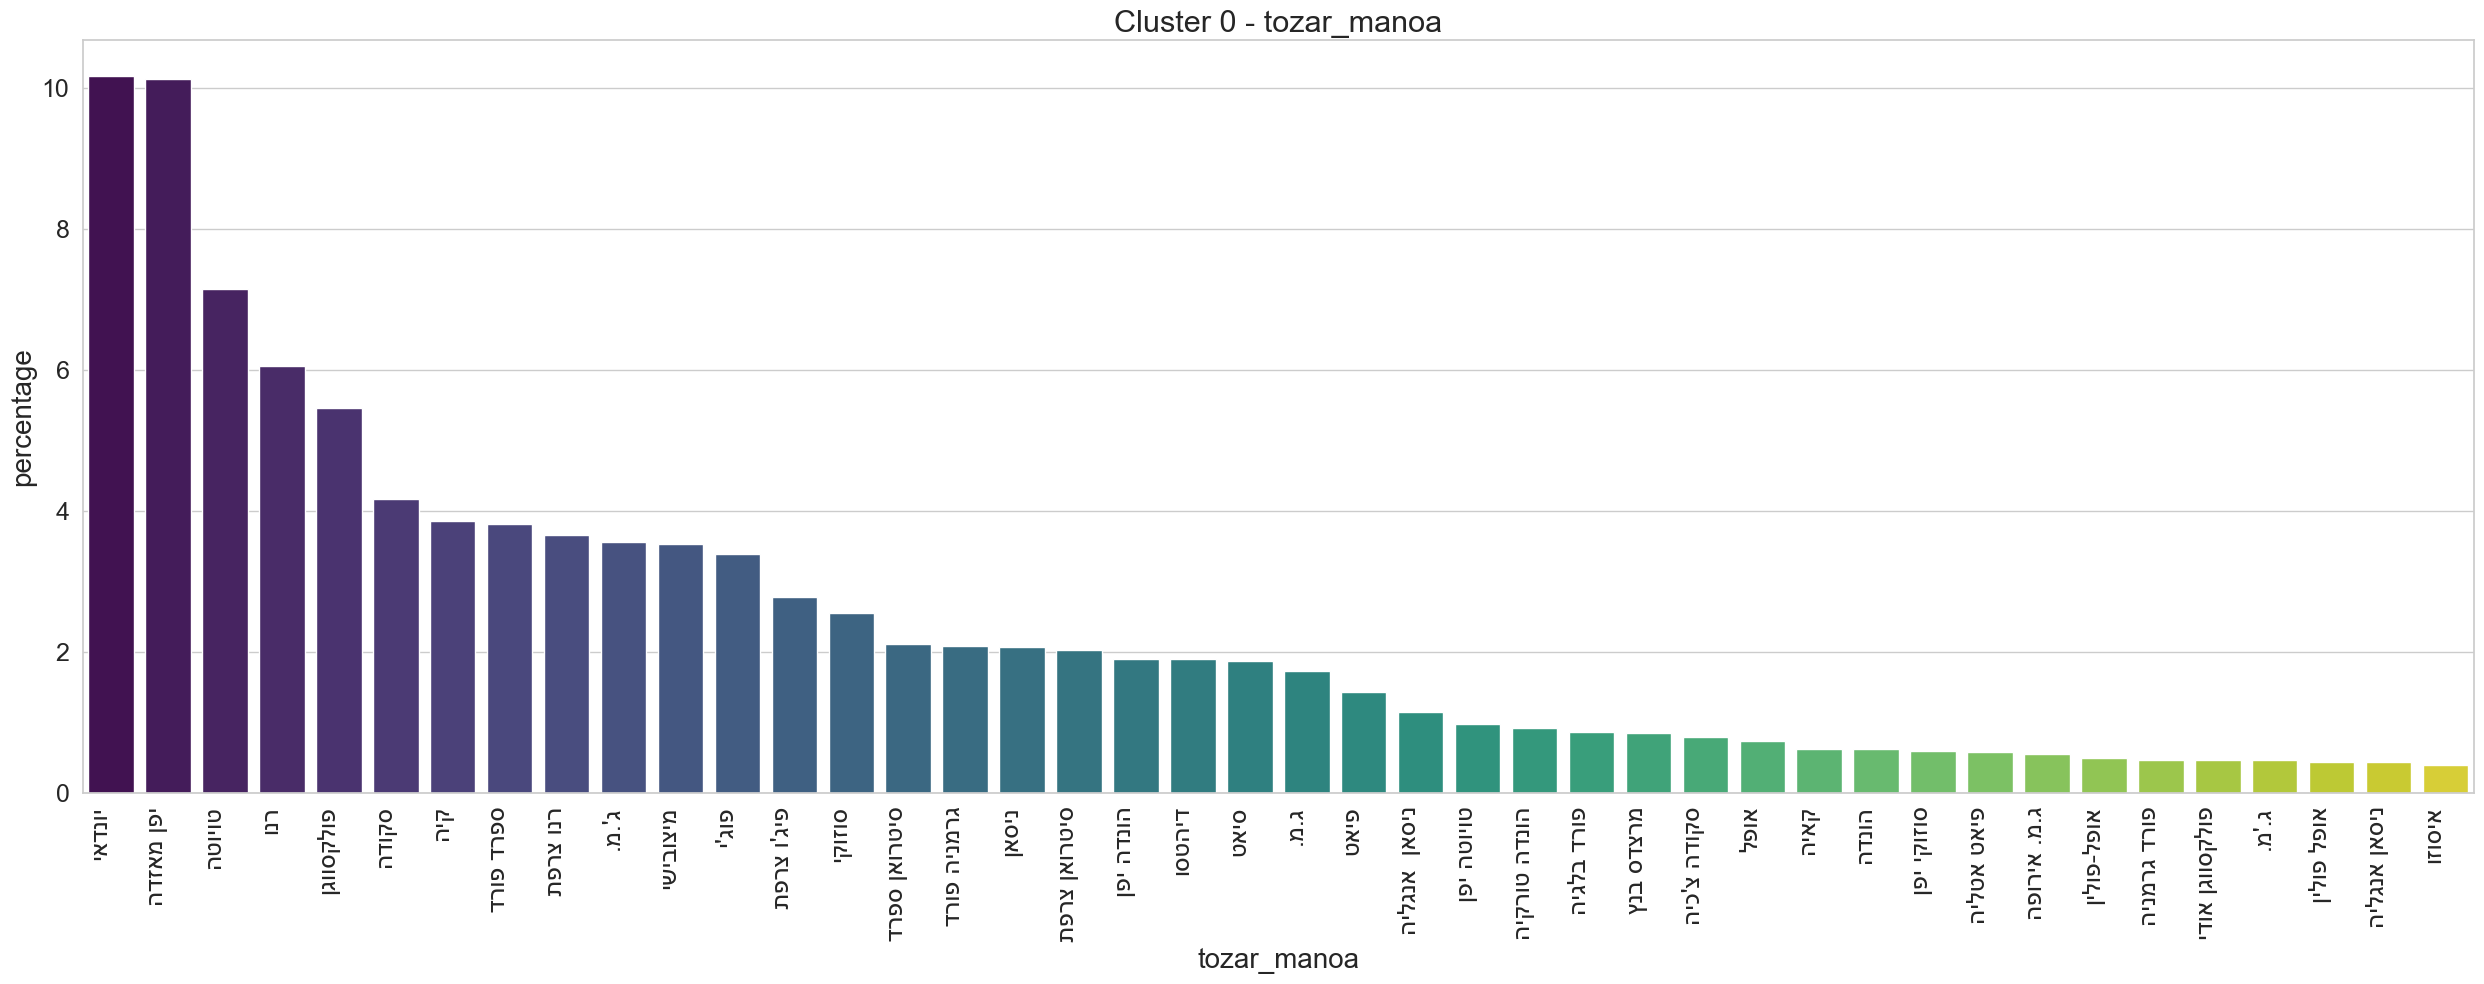

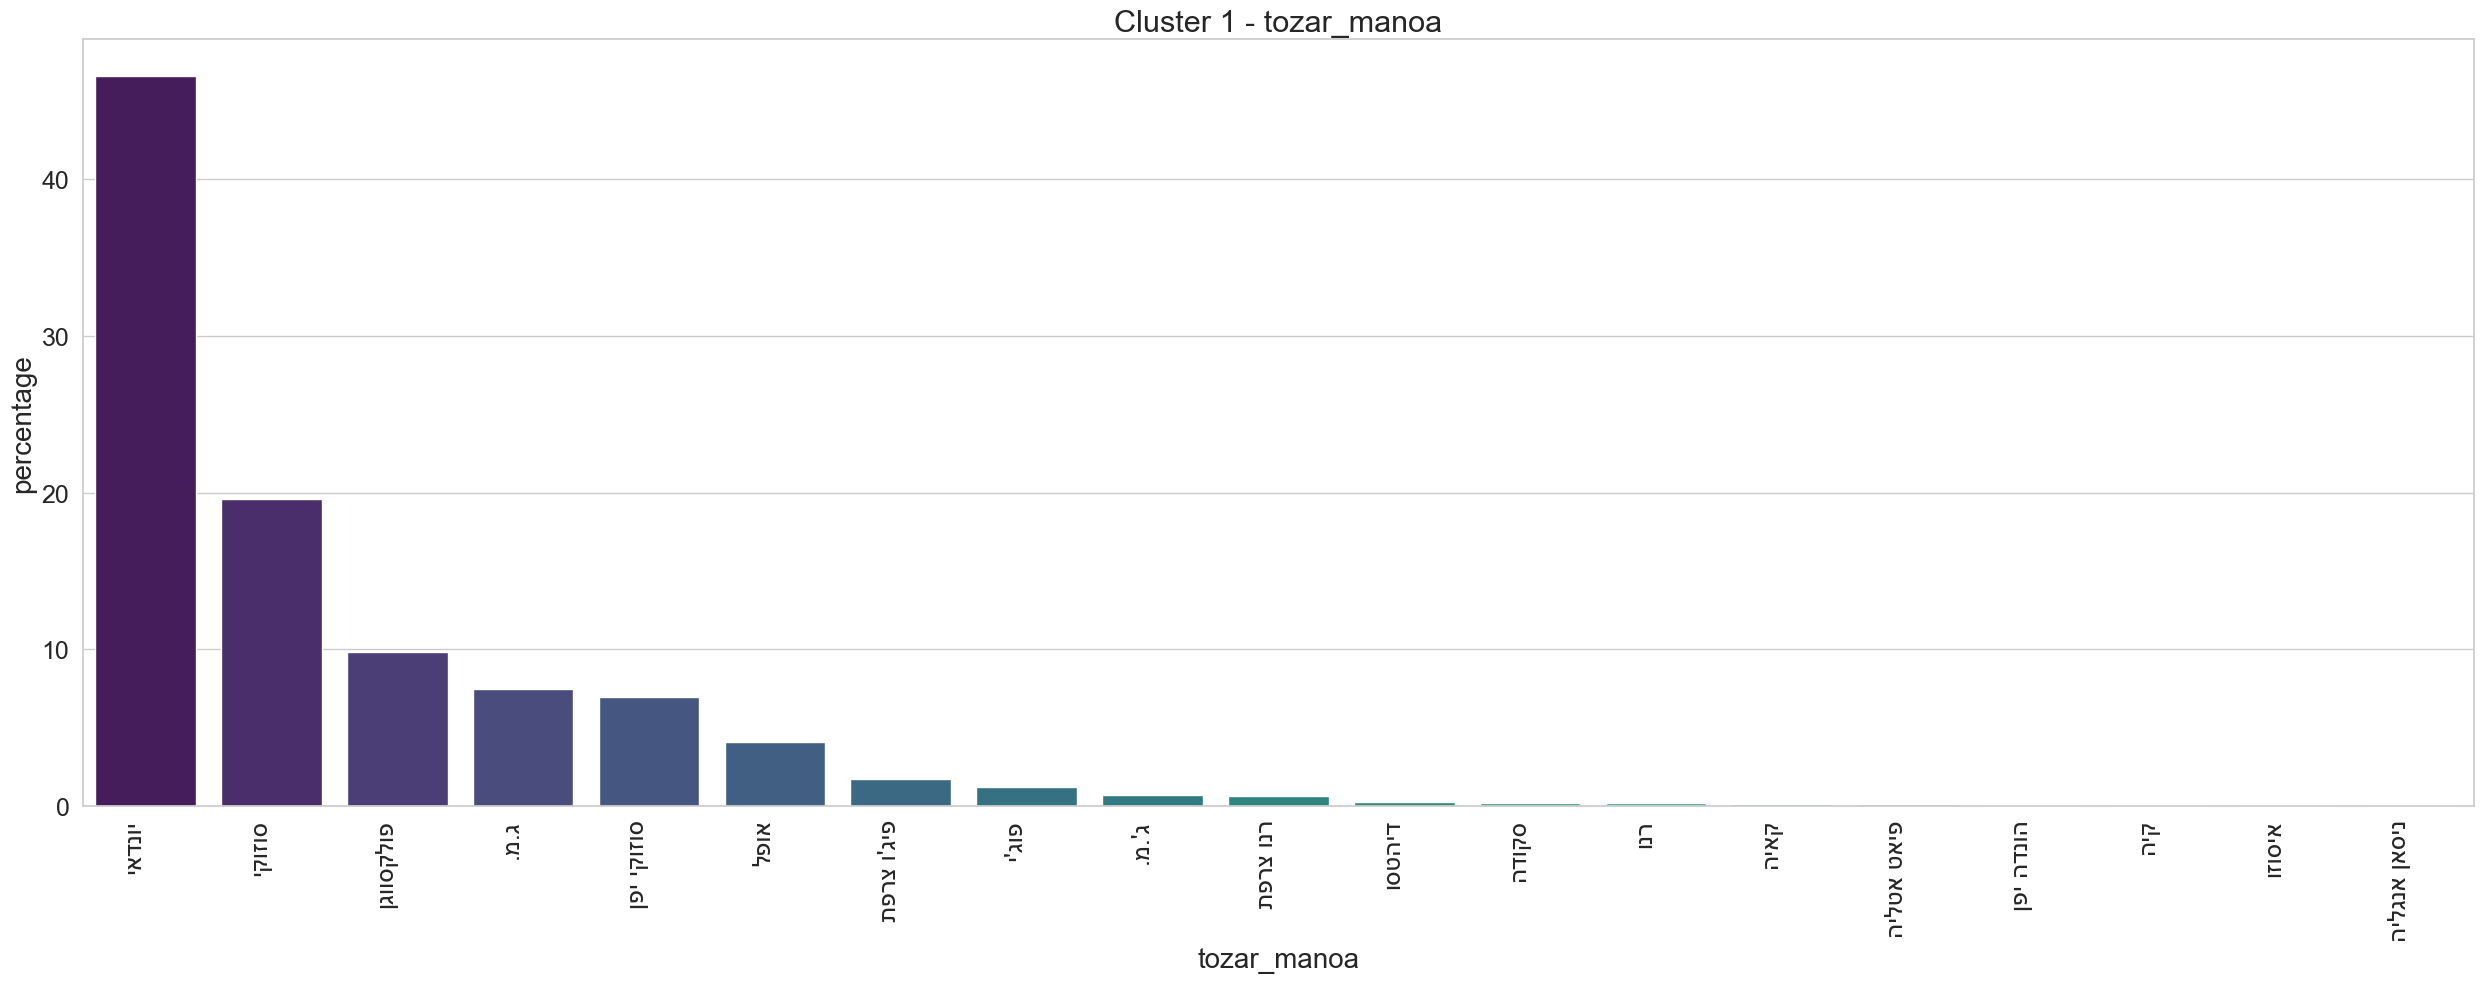

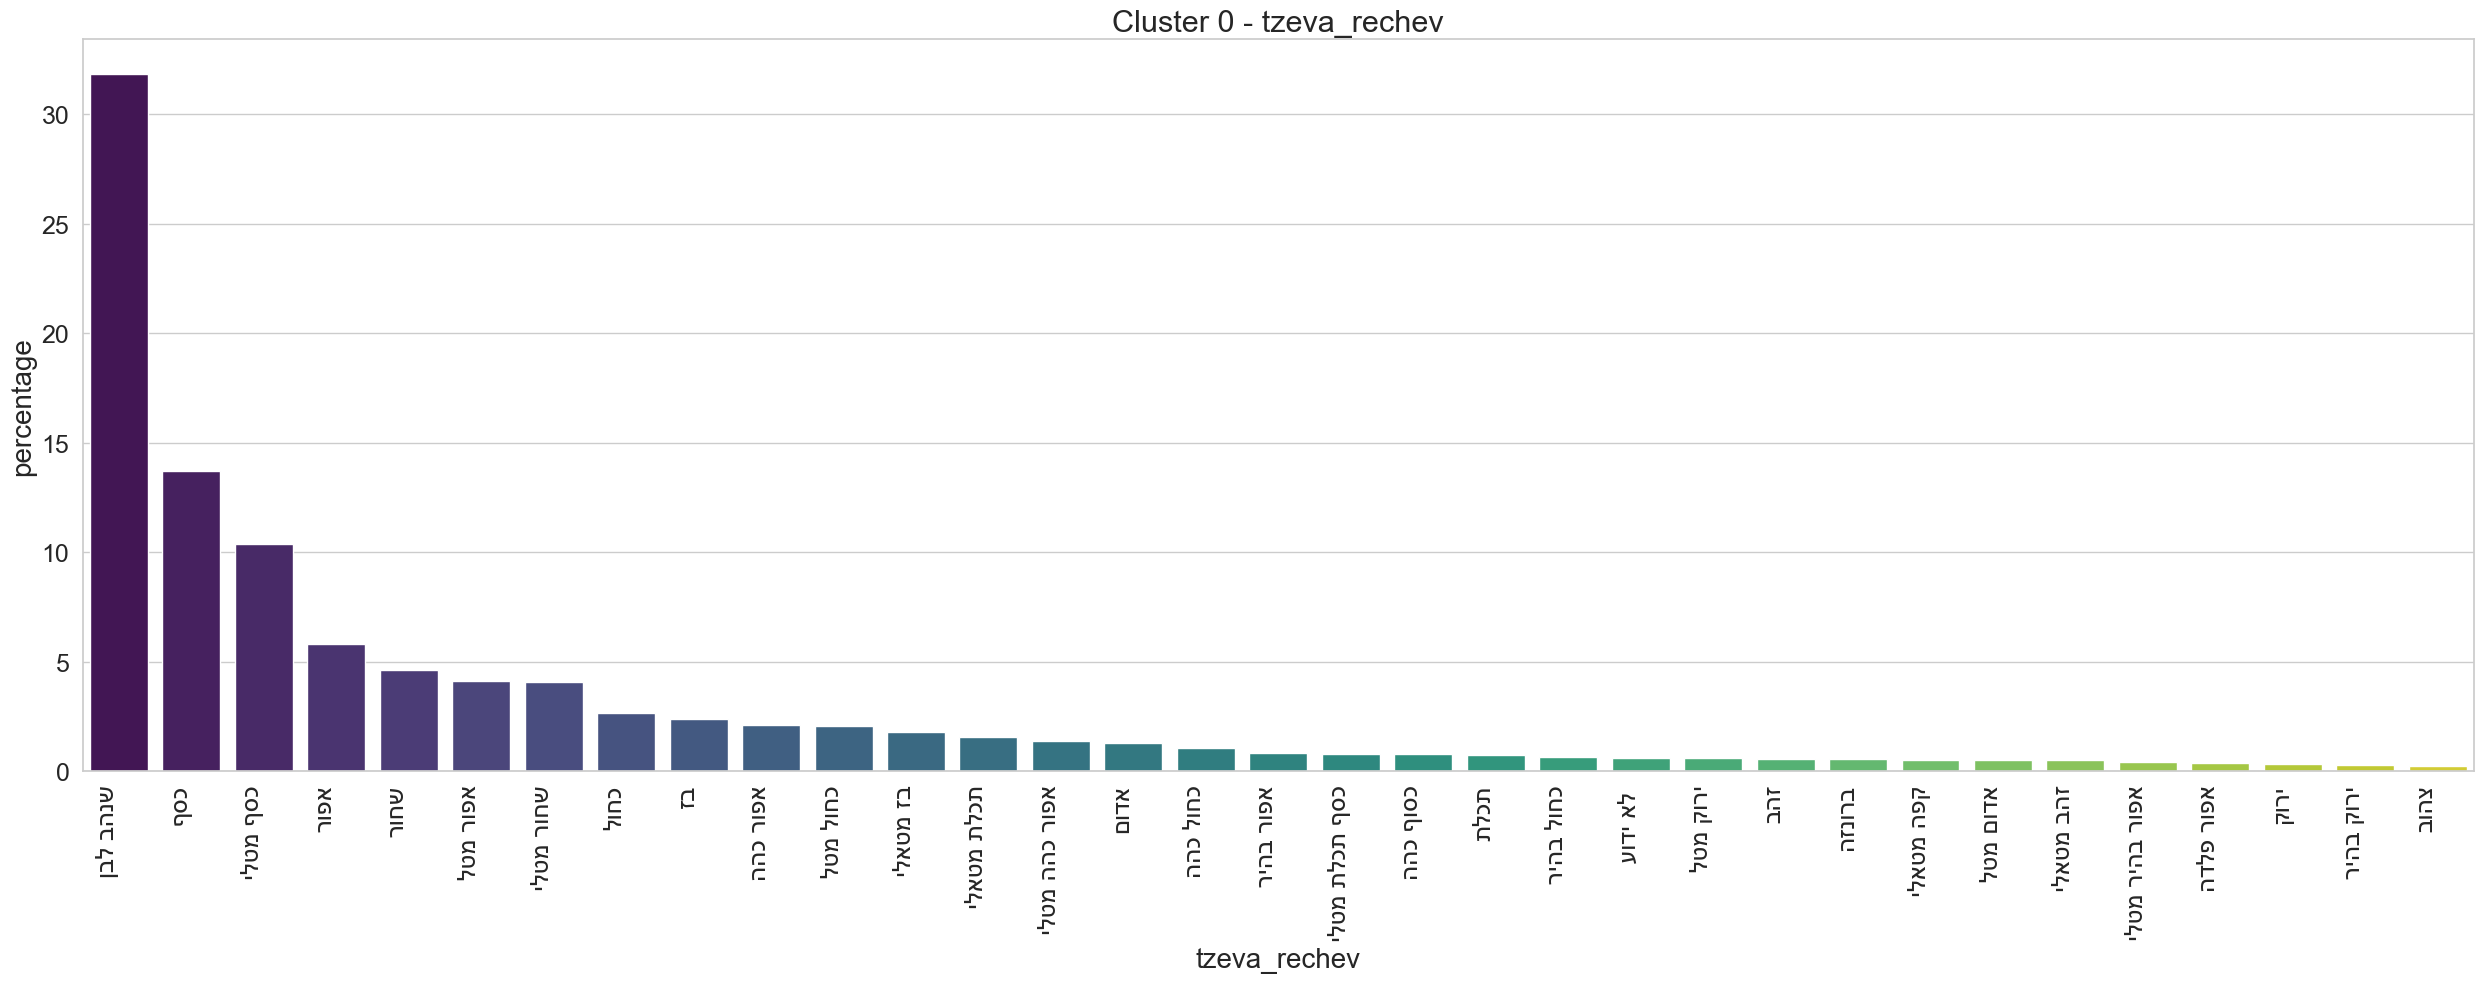

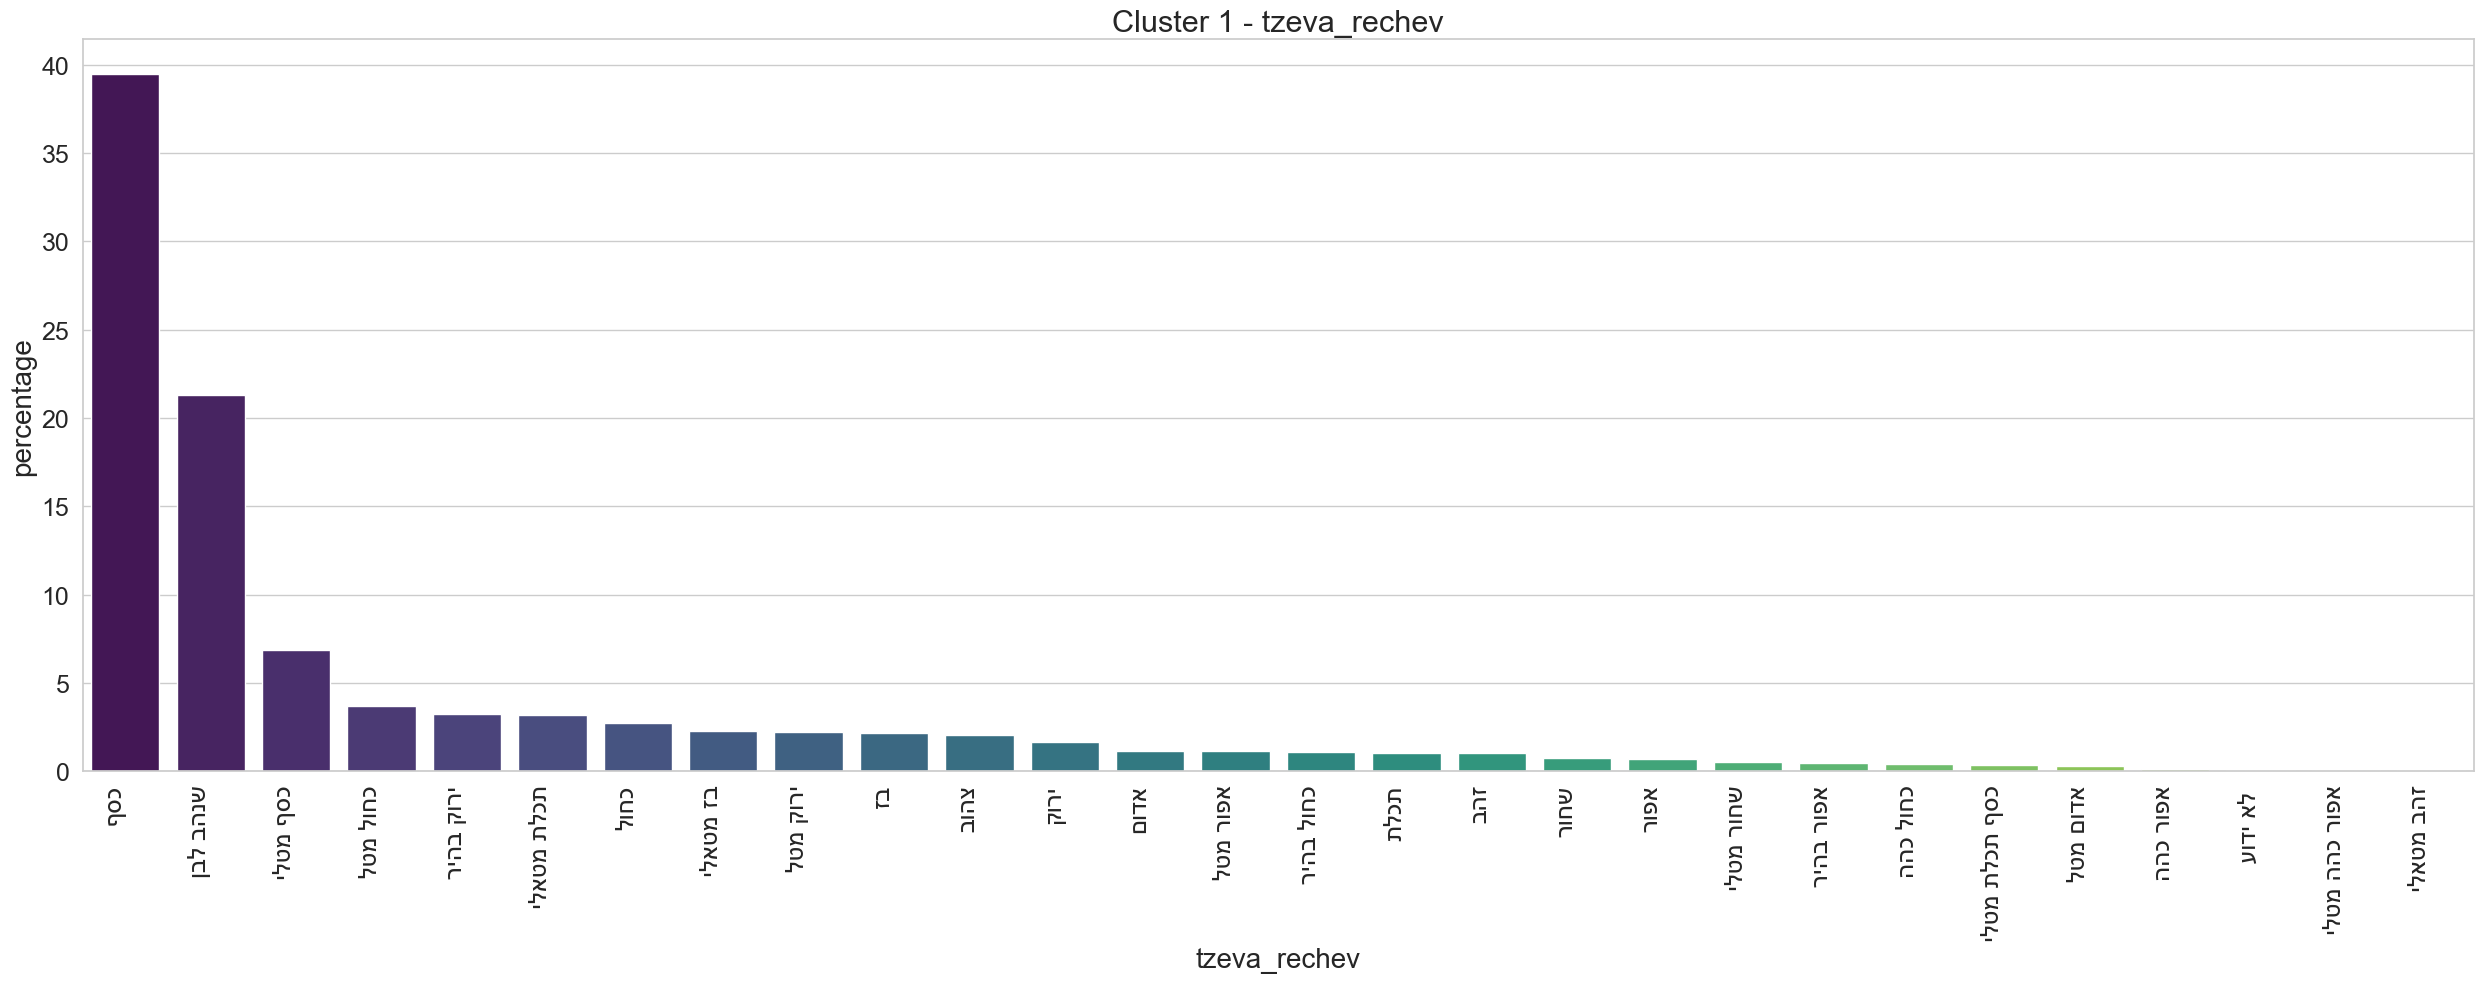

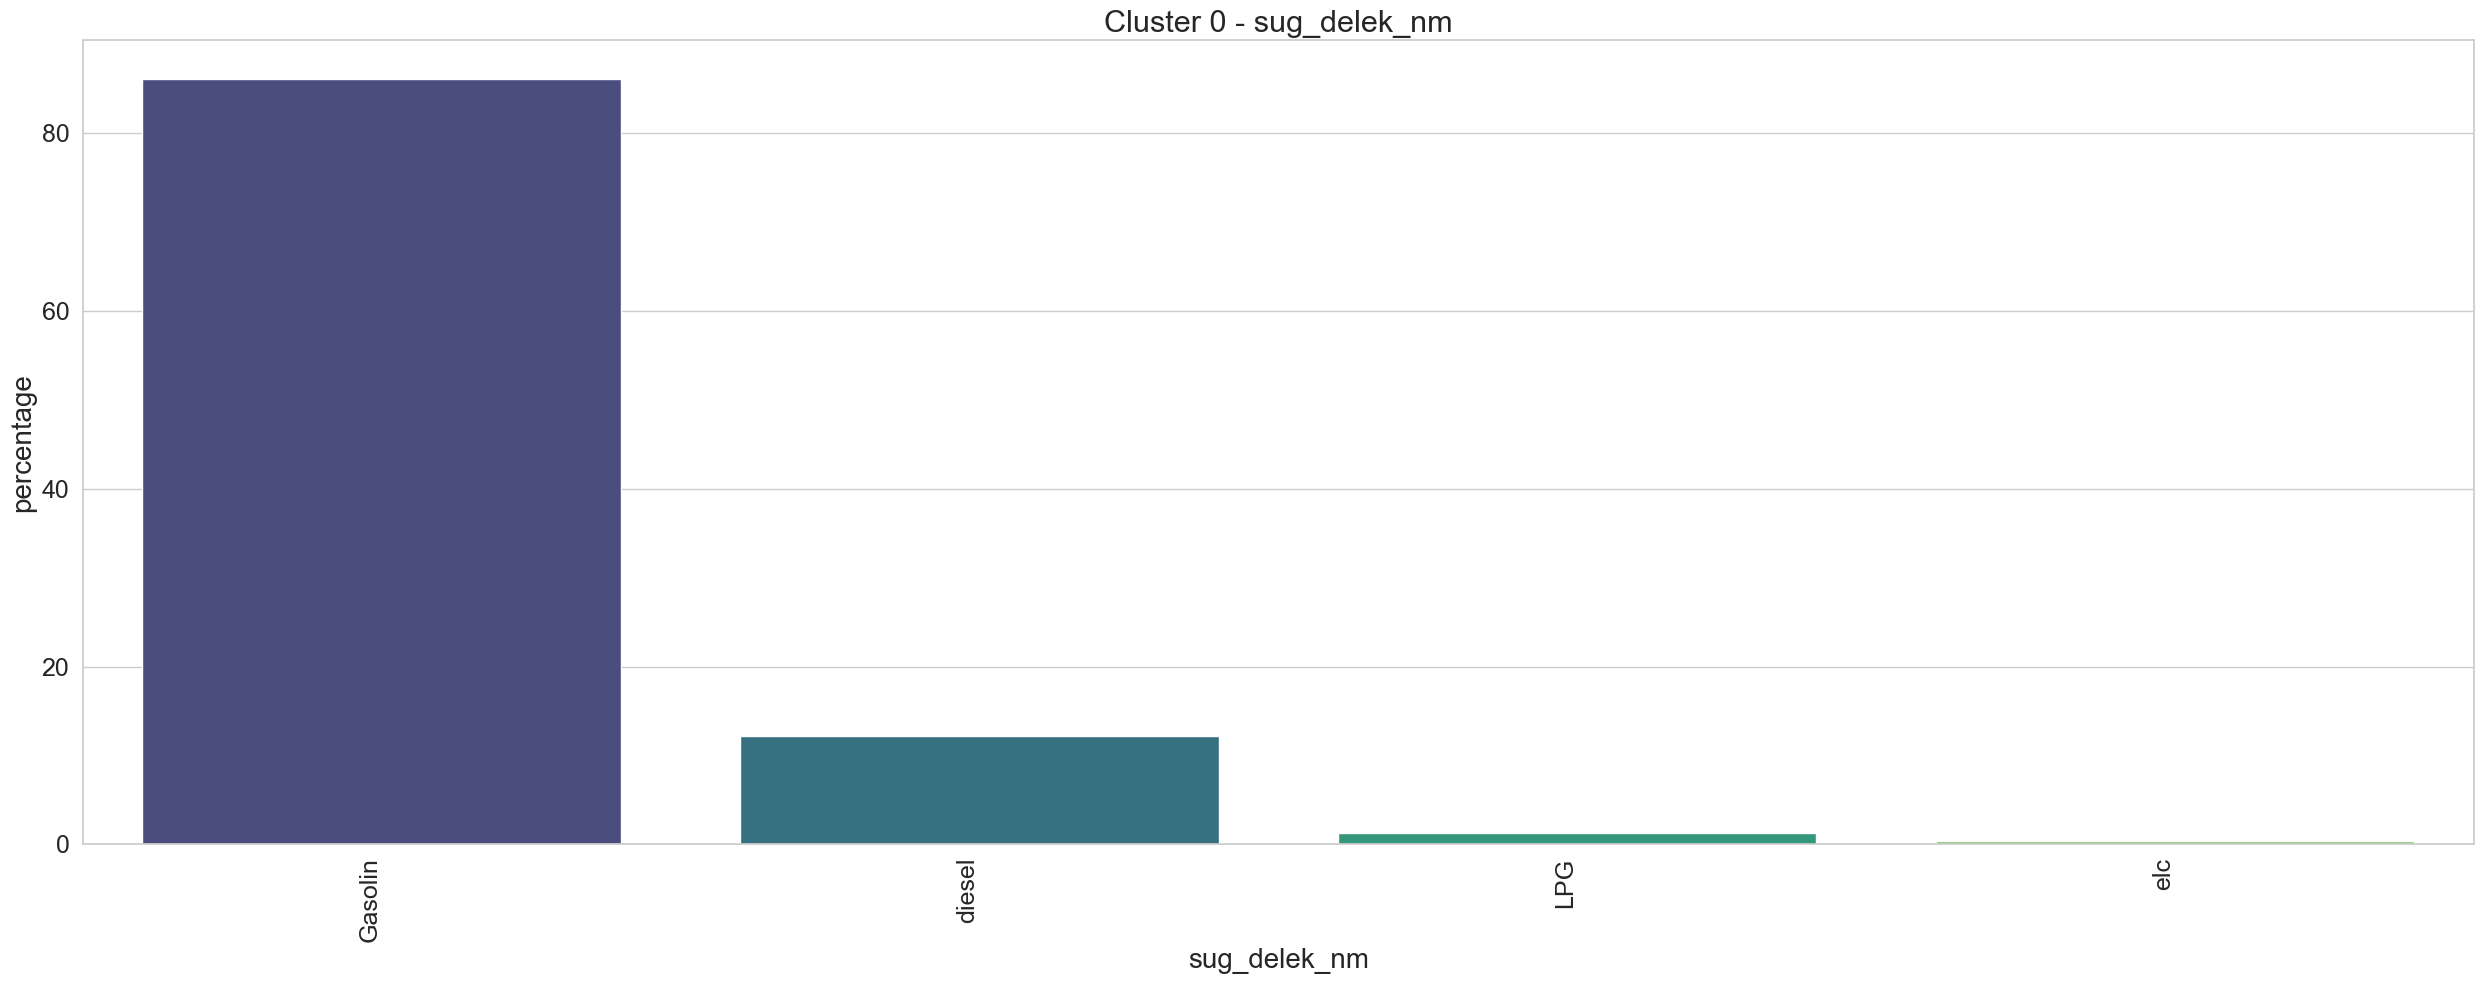

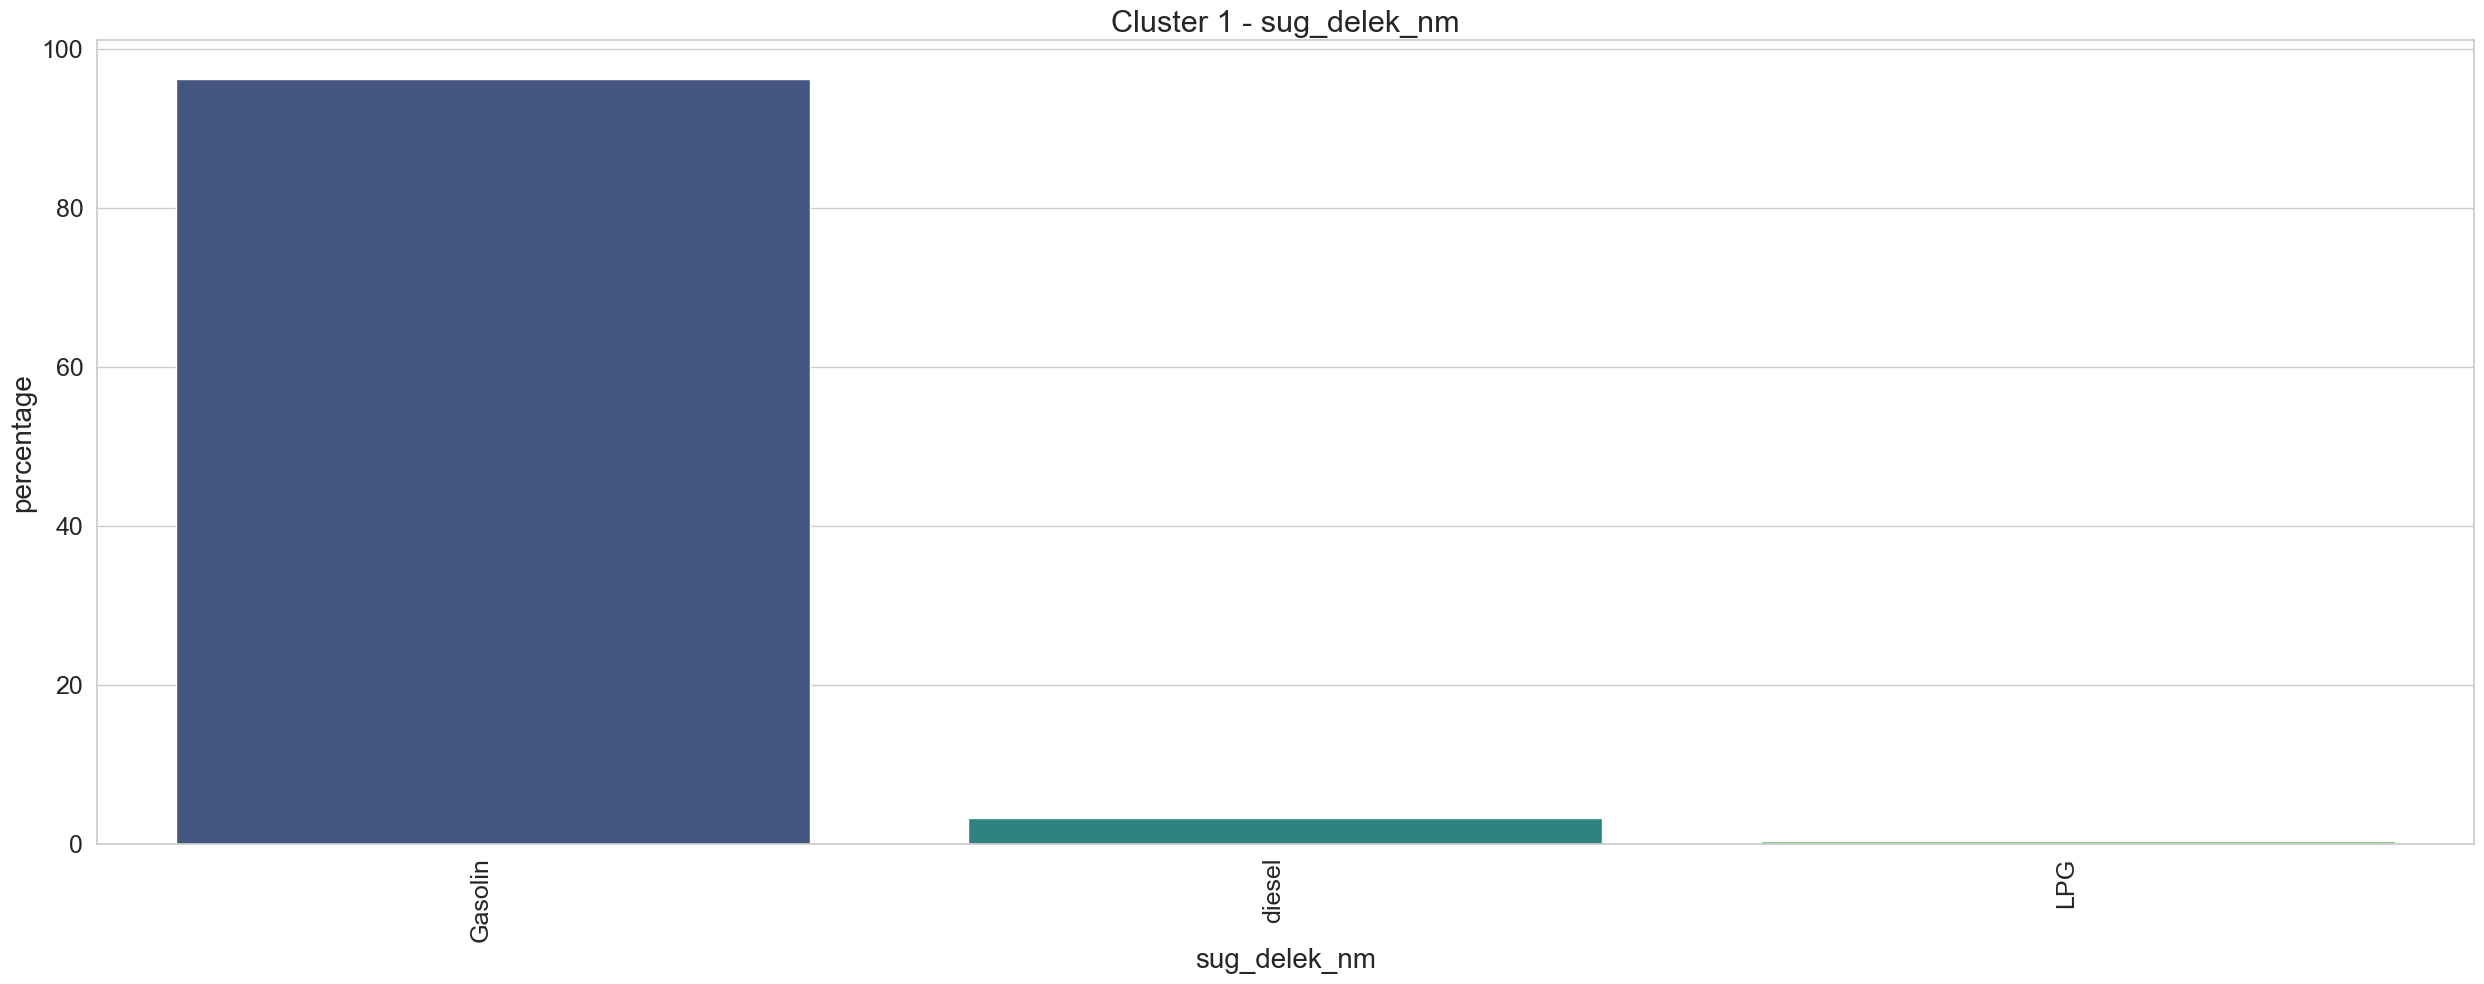

In [92]:
analyze_categorical(df, 'cluster_labels_karnel', categorical_cols)

### We built a function that shows the quantity of each value from each categorical column in each cluster. We saw that the 2 clusters have relatively the same amount in relation to the initial amount in the data from each category in all the columns. Therefore, the first conclusion we reached is that there is no difference in terms of categorical data between the clusters.

In [93]:
numeric_cols = ['mishkal_kolel','shnat_yitzur_and_aliya_lakvish','ramat_eivzur_betihuty'] 

In [94]:
def analyze_numerical_and_show_stats(df, cluster_col, num_cols, bins=10, plots_per_row=3):
    for num_col in num_cols:
        unique_clusters = df[cluster_col].unique()
        num_clusters = len(unique_clusters)

        num_rows = max(1, (num_clusters + plots_per_row - 1) // plots_per_row)  
        fig_width = plots_per_row * 25 
        fig_height = num_rows * 20 

        fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(fig_width, fig_height), sharey=True)

        if not isinstance(axes, np.ndarray):
            axes = np.array([axes])

        axes = axes.flatten()
        
        for i, cluster in enumerate(unique_clusters):
            cluster_df = df[df[cluster_col] == cluster]
            ax = axes[i % plots_per_row] if num_clusters == 1 else axes[i]
            sns.histplot(cluster_df[num_col], bins=bins, ax=ax, kde=False)
            ax.set_title(f'Cluster {cluster}', fontsize=60)
            ax.set_xlabel(num_col, fontsize=60)
            ax.set_ylabel('Frequency', fontsize=60)
            ax.tick_params(axis='x', labelrotation=45, labelsize=40)
            ax.tick_params(axis='y', labelsize=60)

        plt.tight_layout()
        plt.show()

        stats_data = {f'Cluster {cluster}': df[df[cluster_col] == cluster][num_col].describe() for cluster in unique_clusters}
        stats_df = pd.DataFrame(stats_data)
        
        print(f"\nDescriptive statistics summary for {num_col}:")
        display(stats_df) 

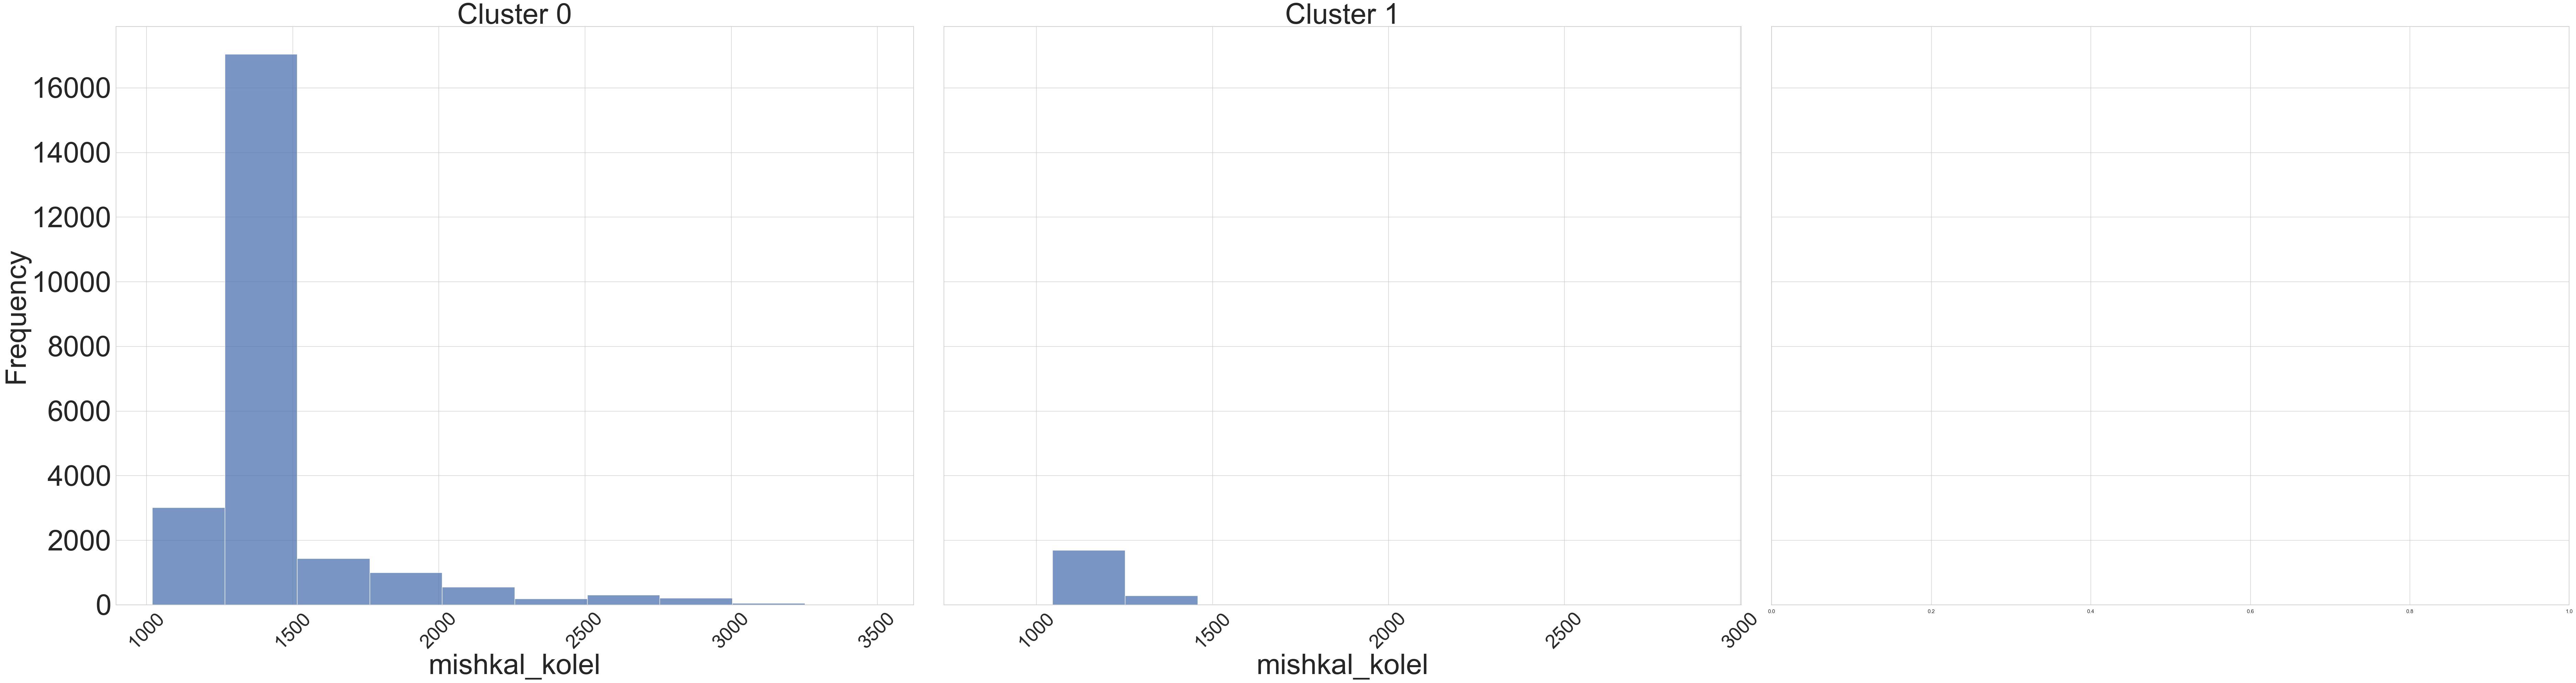


Descriptive statistics summary for mishkal_kolel:


,Cluster 0,Cluster 1
count,23794.000000,2009.000000
mean,1467.418173,1134.549527
std,305.695161,96.958906
min,1020.000000,840.000000
25%,1300.000000,1100.000000
50%,1500.000000,1100.000000
75%,1500.000000,1100.000000
max,3500.000000,2900.000000


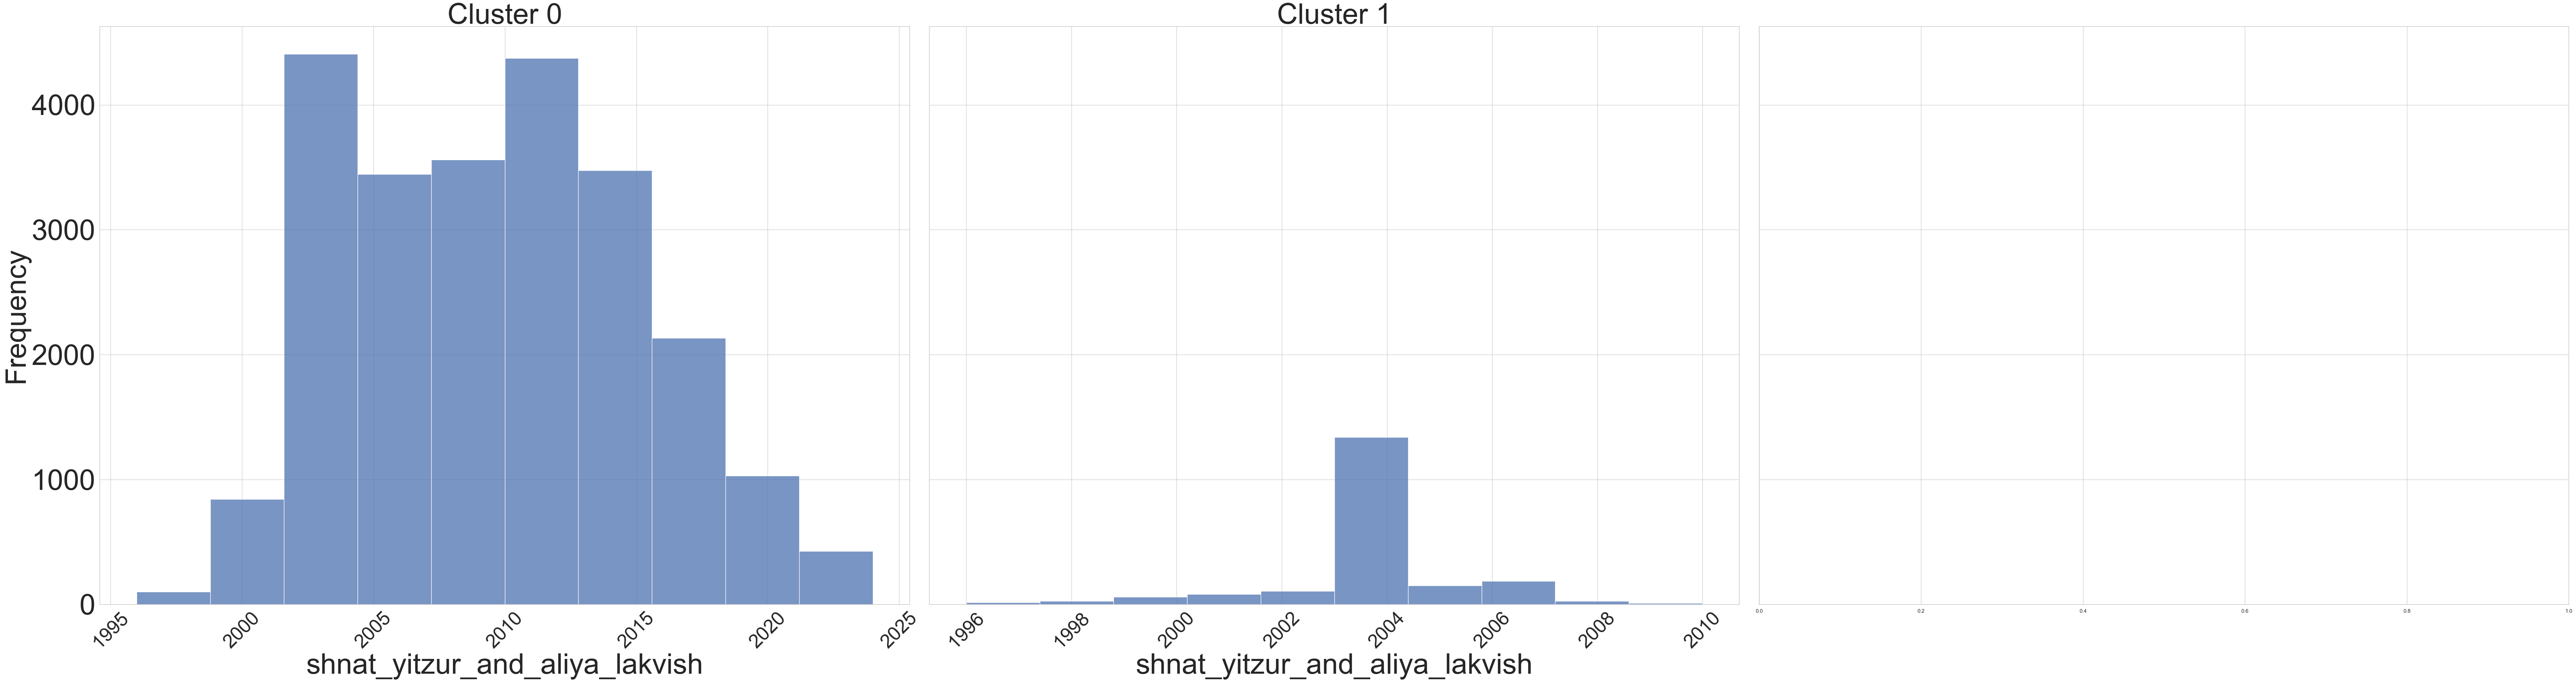


Descriptive statistics summary for shnat_yitzur_and_aliya_lakvish:


,Cluster 0,Cluster 1
count,23794.000000,2009.000000
mean,2009.579054,2003.688900
std,5.338686,1.750151
min,1996.000000,1996.000000
25%,2005.000000,2003.000000
50%,2009.000000,2004.000000
75%,2013.000000,2004.000000
max,2024.000000,2010.000000


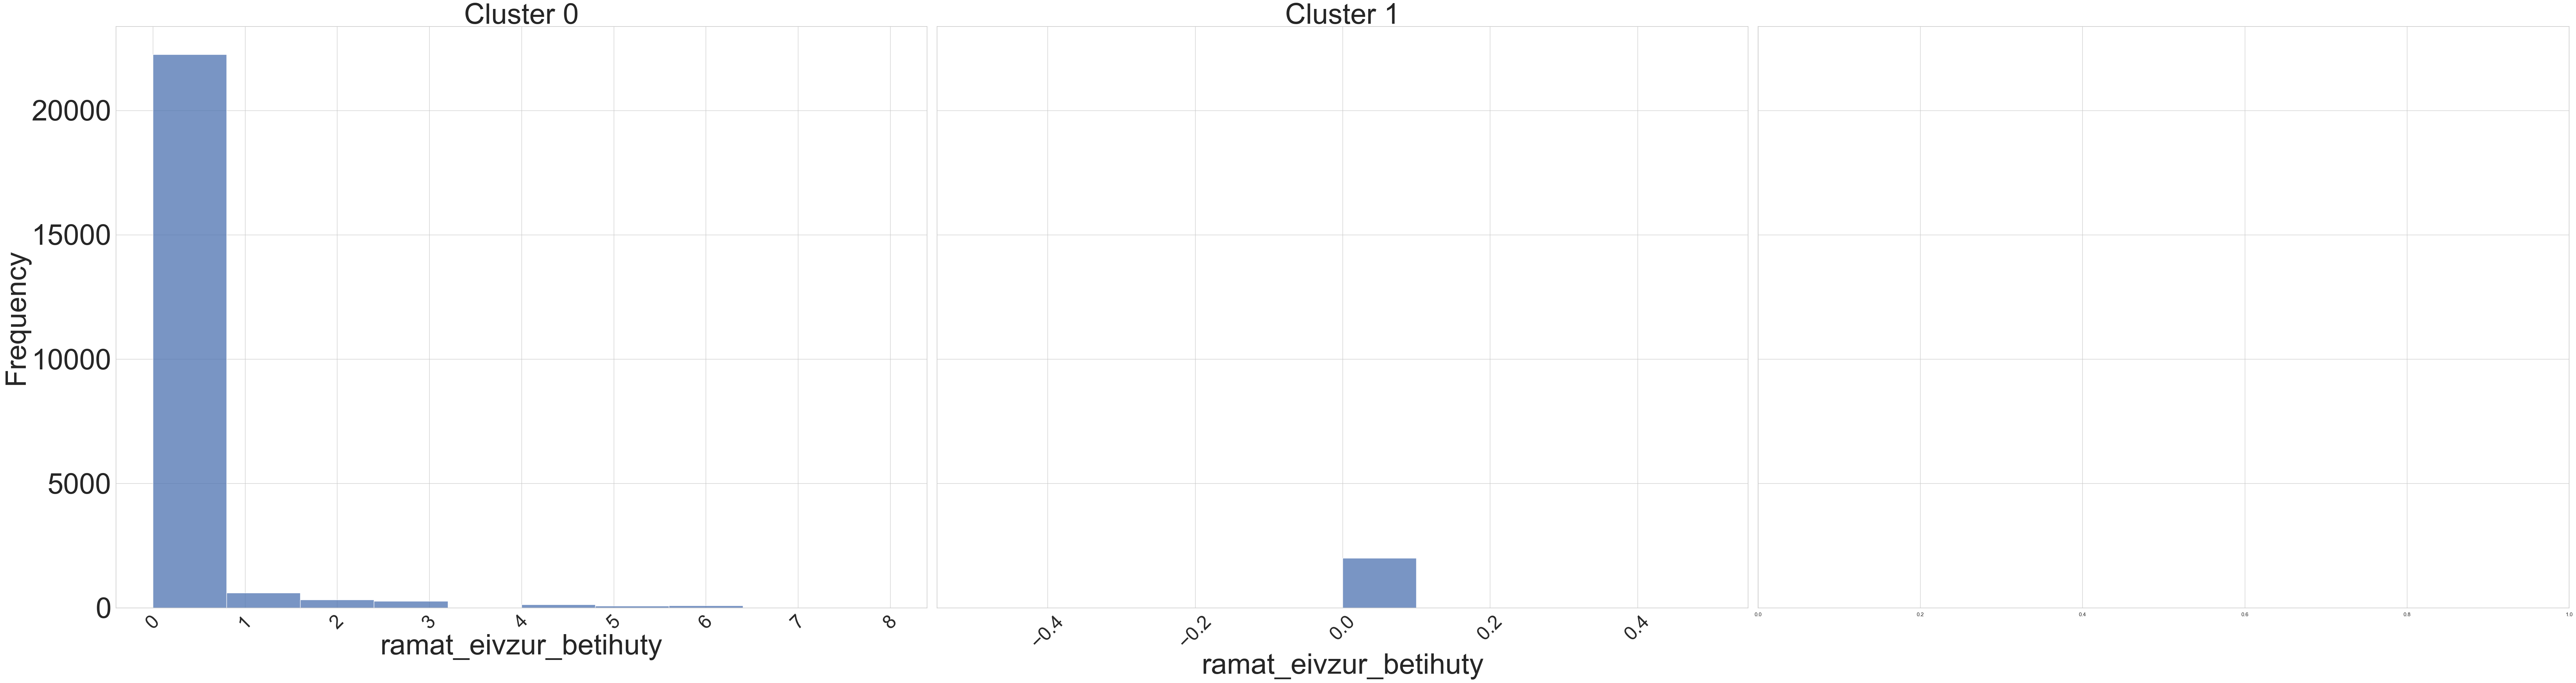


Descriptive statistics summary for ramat_eivzur_betihuty:


,Cluster 0,Cluster 1
count,23794.000000,2009.0
mean,0.155754,0.0
std,0.712798,0.0
min,0.000000,0.0
25%,0.000000,0.0
50%,0.000000,0.0
75%,0.000000,0.0
max,8.000000,0.0


In [95]:
analyze_numerical_and_show_stats(df, 'cluster_labels_karnel', numeric_cols)


In [96]:
df

,tozeret_nm,degem_nm,sug_rechev_nm,tozar_manoa,degem_manoa,mishkal_kolel,ramat_gimur,ramat_eivzur_betihuty,kvutzat_zihum,shnat_yitzur_and_aliya_lakvish,...,zmig_ahori,sug_delek_nm,horaat_rishum,kinuy_mishari,bitul_year,bitul_month,vehicle_category,vehicle_category_hebrew_fixed,cluster_labels,cluster_labels_karnel
0,פולקסווגן גרמנ,7EMH49,מרכב אחוד,פולקסוגן גרמני,CFC,1300,MULTIVAN,0,15,2012,...,255/45 R18,diesel,120191,GOLF,2019,6,Private Vehicle,Private Vehicle,1,0
1,פורד תורכיה,PT2,מרכב אחוד,טורקיה פורד,KKDA,1500,S,0,15,2012,...,195/65R15,diesel,121663,TOURNEO CONNECT,2019,5,Private Vehicle,Private Vehicle,1,0
2,פיאט תורכיה,263WXC1A,מרכב אחוד,פיאט,263A2000,2090,TOP BASE,0,15,2012,...,195/65R15,diesel,0,DOBLO,2019,2,Van \ Jeep,Van \ Jeep,0,0
3,קיה קוריאה,JC5248,מרכב אחוד,יונדאי,D4CB,2850,EX,0,0,2008,...,245/70R16,diesel,0,PICANTO,2019,12,Van \ Jeep,Van \ Jeep,2,0
4,קיה קוריאה,MB7543,מרכב אחוד,קאיה,J3,2920,LX,0,0,2007,...,225/70R16,diesel,0,PICANTO,2020,3,Van \ Jeep,Van \ Jeep,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29987,סיטרואן צרפת,LCNFUF,פרטי נוסעים,סיטרואן צרפת,NFU,1794,SX,0,15,2008,...,205/55R16,Gasolin,0,C4,2023,7,Private Vehicle,Private Vehicle,0,0
29988,פיג'ו צרפת,3HRFNF,פרטי נוסעים 5 דלתות,פיג'ו צרפת,RFN,1300,SW PACK,0,0,2004,...,205/55R16,Gasolin,0,307,2023,7,Private Vehicle,Private Vehicle,4,0
29989,פיג'ו צרפת,3CNFUF,פרטי נוסעים 5 דלתות,פיג'ו צרפת,NFU,1300,XT,0,0,2006,...,195/65R15,Gasolin,0,307,2023,7,Private Vehicle,Private Vehicle,4,0
29998,טויוטה טורקיה,ZGR21L-GRXEPW,פרטי נוסעים,טויוטה,2ZR,1500,GLI,0,15,2009,...,205\60R16,Gasolin,0,COROLLA,2023,10,Private Vehicle,Private Vehicle,0,0


In [97]:
def calculate_mean_time_on_road(df, cluster_col, year_of_alita_col, cancellation_year_col):
    df['time_on_road'] = df[cancellation_year_col] - df[year_of_aliya_col]
    
    mean_time_on_road = df.groupby(cluster_col)['time_on_road'].mean()
    
    return mean_time_on_road

cluster_col = 'cluster_labels_karnel'
year_of_aliya_col = 'shnat_yitzur_and_aliya_lakvish'
cancellation_year_col = 'bitul_year'
calculate_mean_time_on_road(df,cluster_col,year_of_aliya_col,cancellation_year_col)

cluster_labels_karnel
0    12.804531
1    17.130911
Name: time_on_road, dtype: float64

Mean time on road for each cluster:
 cluster_labels_karnel
0    12.804531
1    17.130911
Name: time_on_road, dtype: float64


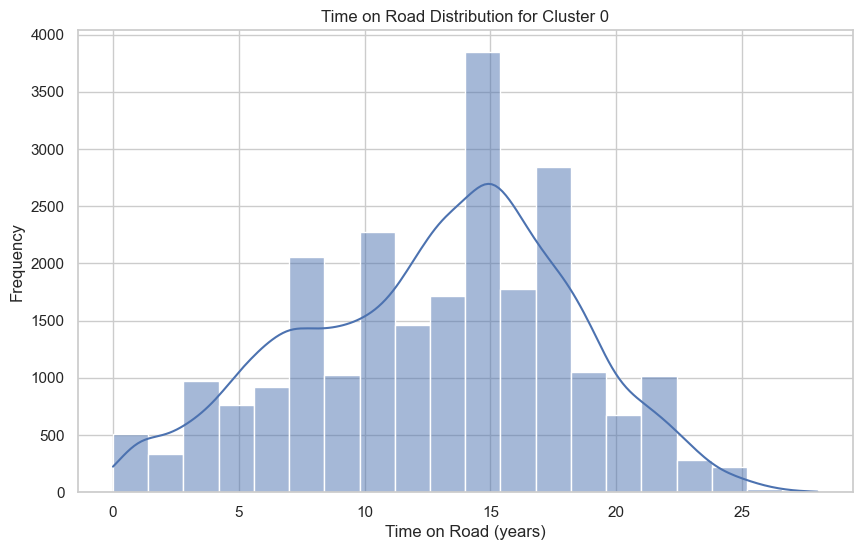

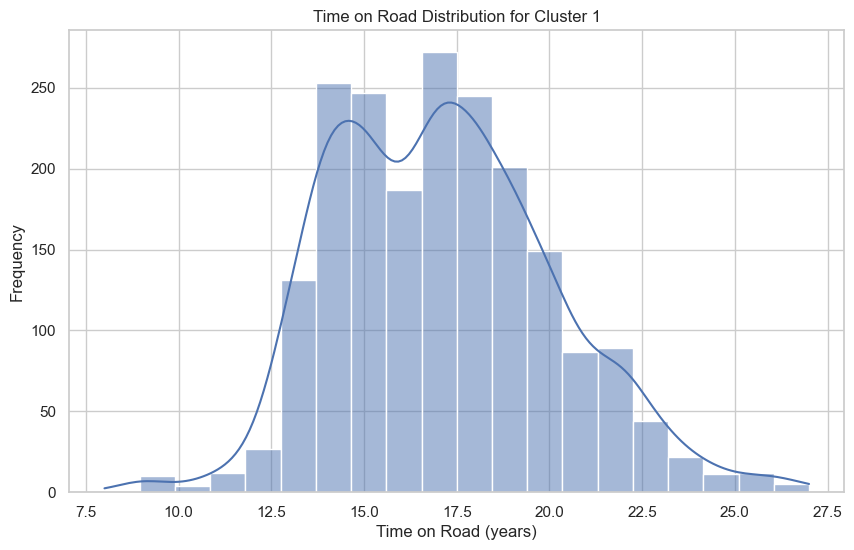

In [106]:
def calculate_and_visualize_time_on_road(df, year_of_manufacture_col, cancellation_year_col, cluster_col):
    df['time_on_road'] = df[cancellation_year_col].astype(int) - df[year_of_manufacture_col].astype(int)
    mean_time_on_road_per_cluster = df.groupby(cluster_col)['time_on_road'].mean()
    print("Mean time on road for each cluster:\n", mean_time_on_road_per_cluster)
    clusters = df[cluster_col].unique()
    for cluster in clusters:
        cluster_data = df[df[cluster_col] == cluster]
        plt.figure(figsize=(10, 6))
        sns.histplot(cluster_data['time_on_road'], bins=20, kde=True)
        plt.title(f'Time on Road Distribution for Cluster {cluster}')
        plt.xlabel('Time on Road (years)')
        plt.ylabel('Frequency')
        plt.show()

calculate_and_visualize_time_on_road(df, 'shnat_yitzur_and_aliya_lakvish', 'bitul_year', 'cluster_labels_karnel')

## Conclusion:
### <blockquote> In the large cluster (cluster 0) there were vehicles with medium-high weight both in terms of average values and in terms of the end of the range of values, unlike the small cluster (cluster 1) where there were vehicles with low-medium weight. </blockquote>
### <blockquote>In the large cluster, the time on the road was approximately 12 years, whereas in the small cluster, the years were 17 years. The years of production and going on the road in the small cluster were in the range of 1996-2010 as opposed to the large cluster where they were in the range of 1996-2024. </blockquote>

#### cluster 1: The cluster includes little part from the data (about 2000 in each iteration) so it may also be abnormal data. The information relates to cars that were driven up until 2010. Despite this, it can be seen that vehicles in this cluster survived a long time on the road until the malfunction that disabled them. The vehicles in this cluster are vehicles that weigh less, when we looked at their types we saw private vehicles on the border of mini vehicles.This leads us to believe that small- to medium-sized cars that are put on the road these days are most likely less prone to malfunctions and repair needs. The consumer may find this conclusion useful in determining whether to buy this kind of car. The manufacturer can use this finding to determine whether to continue producing cars that are comparable to those in this cluster. 

In [107]:
df[df['mishkal_kolel']<1000].head()

,tozeret_nm,degem_nm,sug_rechev_nm,tozar_manoa,degem_manoa,mishkal_kolel,ramat_gimur,ramat_eivzur_betihuty,kvutzat_zihum,shnat_yitzur_and_aliya_lakvish,...,sug_delek_nm,horaat_rishum,kinuy_mishari,bitul_year,bitul_month,vehicle_category,vehicle_category_hebrew_fixed,cluster_labels,cluster_labels_karnel,time_on_road
11466,דייהטסו-יפן,שרייד G200LS-GMDE,פרטי נוסעים 5 דלתות,דיהטסו,HC-E,845,DLX,0,0,1999,...,Gasolin,0,SIRION,2023,9,Private Vehicle,Private Vehicle,4,1,24
12345,דייהטסו-יפן,שרייד G200LS-GMDE,פרטי נוסעים 5 דלתות,דיהטסו,HC-E,845,DLX,0,0,1999,...,Gasolin,0,SIRION,2023,1,Private Vehicle,Private Vehicle,4,1,24
21503,דייהטסו-יפן,שרייד G200LS-GMDE,פרטי נוסעים 5 דלתות,דיהטסו,HC-E,845,DLX,0,0,1999,...,Gasolin,0,SIRION,2023,9,Private Vehicle,Private Vehicle,4,1,24
27863,קיה קוריאה,DA2423,פרטי נוסעים 5 דלתות,קאיה,B3,840,DLX,0,0,1997,...,Gasolin,0,PICANTO,2023,5,Private Vehicle,Private Vehicle,4,1,26
29797,קיה קוריאה,DA2423,פרטי נוסעים 5 דלתות,קאיה,B3,840,DLX,0,0,1997,...,Gasolin,0,PICANTO,2023,7,Private Vehicle,Private Vehicle,4,1,26


In [2]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
